# concatenating Glassdoor and Kununu Ratings, And analyzing the time-series ratings
-------------------

> <i>Description: In this notebook, we begin by preprocessing the data, which includes converting columns to categorical types, adding department and seniority information, and managing country-specific data. We then examine the data in a time-series format to analyze patterns and understand significance. Additionally, we explore the relationships between data trends and various campaigns or events. Findings from each section of the analysis are reported to provide insights and support decision-making.</i>


Input Files: 
1) Glassdoor_reviews_gathered.csv
2) Kununu_reviews_gathered.csv
3) cities_with_countries.csv
4) departments_seniority.csv


Output:
1) ratings_preprocessed.csv
2) PNGs for presentation

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import ast
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
glassdoor_data = pd.read_csv('../initial_data/Glassdoor_reviews_gathered.csv')
kununu_data = pd.read_csv('../initial_data/Kununu_reviews_gathered.csv')
print('glassdoor:')
print('length: ', len(glassdoor_data))
print('columns: ', glassdoor_data.columns)
print('kununu:')
print('length: ', len(kununu_data))
print('columns: ', kununu_data.columns)

glassdoor:
length:  1852
columns:  Index(['Unnamed: 0', 'reviewId', 'advice', 'cons', 'employer.shortName',
       'employmentStatus', 'isCurrentJob', 'jobTitle.text', 'location.name',
       'pros', 'ratingBusinessOutlook', 'ratingCareerOpportunities',
       'ratingCeo', 'ratingCompensationAndBenefits', 'ratingCultureAndValues',
       'ratingDiversityAndInclusion', 'ratingOverall',
       'ratingRecommendToFriend', 'ratingSeniorLeadership',
       'ratingWorkLifeBalance', 'reviewDateTime', 'summary'],
      dtype='object')
kununu:
length:  607
columns:  Index(['Unnamed: 0', 'uuid', 'type', 'title', 'score', 'createdAt', 'ratings',
       'responses', 'texts', 'position', 'company', 'department', 'reactions',
       'recommended', 'trainee', 'helpful'],
      dtype='object')


## Data Preprocessing

In [3]:
# Handling Countires 
# We got the cities_with_countries.csv by giving the name and city that is extracted to gpt 4O-mini and getting the cleaned country and city back. As it is a very simple task, it has been done very accurately.
countries = pd.read_csv('cities_with_countries.csv')
glassdoor_data = glassdoor_data.merge(countries[['city', 'country']], left_on='location.name', right_on='city', how='left')
glassdoor_data.drop(columns=['city'], inplace=True)
print('Glassdoor_countries: ',glassdoor_data['country'].value_counts(dropna=False))

kununu_data['country_code'] = kununu_data['company'].apply(lambda x: ast.literal_eval(x)['location']['countryCode'])
kununu_data['country'] = kununu_data['country_code'].apply(lambda x: 'Germany' if x == 'de' else 'Unknown')
print('Kununu_countries: ',kununu_data['country'].value_counts(dropna=False))

Glassdoor_countries:  Unknown        833
Germany        234
England        231
USA            173
Canada         131
France          58
Australia       58
Ireland         25
Brazil          21
Netherlands     18
Mexico          12
Scotland        12
UAE             10
Spain            7
Switzerland      6
Sweden           5
Belgium          4
Turkey           4
India            3
China            2
Portugal         2
Argentina        1
Austria          1
Norway           1
Name: country, dtype: int64
Kununu_countries:  Germany    604
Unknown      3
Name: country, dtype: int64


In [4]:
# handling Kununu score columns
all_ids = []
for i in range(len(kununu_data)):
     kununu_data_str = kununu_data['ratings'][i]
     parsed_data = ast.literal_eval(kununu_data_str)
     result = [(x['id']) for x in parsed_data]

     for item in result:
          if item not in all_ids:
               all_ids.append(item)


# Defining the specific columns to be added
required_columns = [
    'salary_score', 'communication_score', 'atmosphere_score', 'image_score',
    'workLife_score', 'career_score', 'environment_score', 'teamwork_score',
    'oldColleagues_score', 'leadership_score', 'workConditions_score',
    'equality_score', 'tasks_score'
]

# Initialize the required columns with None values for each row
for col in required_columns:
    kununu_data[col] = [None] * len(kununu_data['ratings'])

for index, rating_str in enumerate(kununu_data['ratings']):
    parsed_data = ast.literal_eval(rating_str)
    
    row_data = {f"{item['id']}_score": item['score'] for item in parsed_data}

    # Update the kununu_data dictionary with the scores for required columns
    for col in required_columns:
        if col in row_data:
            kununu_data[col][index] = row_data[col]

kununu_data.head(3)

Unnamed: 0                                  uuid            type  \
0           0  ca6e64a6-c45e-4b04-9d85-8ff633cbe289        employer   
1           1  b11b7978-d151-4249-a747-3ba7501e1bad        employer   
2           2  fe76c408-b3a7-4e8d-be08-4bb67d0868da  apprenticeship   

                                               title  score  \
0                            Außen hui, innen "pfui"    3.7   
1  Top Arbeitgeber / Logistik sehr eingefahrenes ...    3.3   
2     Vielseitige und tolle Ausbildung bei Hugo Boss    4.8   

                   createdAt  \
0  2024-09-21T00:00:00+00:00   
1  2024-09-05T00:00:00+00:00   
2  2024-08-30T00:00:00+00:00   

                                             ratings responses  \
0  [{'id': 'salary', 'score': 2, 'roundedScore': ...        []   
1  [{'id': 'atmosphere', 'score': 4, 'roundedScor...        []   
2  [{'id': 'apprenticeshiptasks', 'score': 4, 'ro...        []   

                                               texts    position  ...  \
0  [{'id': 'negative', 'text': 'Es wird viel zu v...    employee  ...   
1  [{'id': 'positive', 'text': 'Ein super Arbeitg...    employee  ...   
2  [{'id': 'positive', 'text': 'Die vielen Mitarb...  apprentice  ...   

  image_score workLife_score career_score environment_score teamwork_score  \
0           3              4            3                 4              3   
1           4              3            4                 5              4   
2        None           None         None              None           None   

   oldColleagues_score leadership_score workConditions_score equality_score  \
0                    4                4                    5              5   
1                    2                1                    5              2   
2                 None             None                 None           None   

  tasks_score  
0           3  
1           3  
2        None  

[3 rows x 31 columns]

### Combine Equivalent Scores:

- ratingOverall (Glassdoor) with an average score computed from Kununu's columns or just the overall score from Kununu, if it exists.
- ratingWorkLifeBalance (Glassdoor) with workLife_score (Kununu).
- ratingCultureAndValues (Glassdoor) with atmosphere_score and/or communication_score (Kununu).
- ratingDiversityAndInclusion (Glassdoor) with equality_score (Kununu).
- ratingCareerOpportunities (Glassdoor) with career_score (Kununu).
- ratingCompensationAndBenefits (Glassdoor) with salary_score (Kununu).
- ratingSeniorLeadership (Glassdoor) with leadership_score (Kununu).


### For Glassdoor reviews:
- reviewDateTime: createdAt
- reviewId : uuid
- ratingOverall : score
- ratingWorkLifeBalance : workLife_score
- ratingCultureAndValues :  atmosphere_score( on both columns)
- ratingDiversityAndInclusion : equality_score
- ratingCareerOpportunities : career_score
- ratingCompensationAndBenefits : salary_score
- ratingSeniorLeadership : leadership_score

### remaining form Kununu:

atmosphere_score
environment_score
teamwork_score

- image_score
- environment_score
- teamwork_score
- oldColleagues_score
- workConditions_score
- tasks_score


In [5]:
# merging Kununu and Glassdoor scores

glassdoor_data_renamed = glassdoor_data.rename(columns={
    'reviewDateTime': 'createdAt',
    'reviewId': 'uuid',
    'ratingOverall': 'score',
    'ratingWorkLifeBalance': 'workLife_score',
    'ratingDiversityAndInclusion': 'equality_score',
    'ratingCareerOpportunities': 'career_score',
    'ratingCompensationAndBenefits': 'salary_score',
    'ratingSeniorLeadership': 'leadership_score'
})

glassdoor_data_renamed['atmosphere_score'] = glassdoor_data['ratingCultureAndValues']

# Ensure all columns are aligned for concatenation
kununu_columns = set(kununu_data.columns)
glassdoor_columns = set(glassdoor_data_renamed.columns)

# Find columns that are present in only one of the dataframes
missing_in_kununu = glassdoor_columns - kununu_columns
missing_in_glassdoor = kununu_columns - glassdoor_columns

# Add missing columns to both dataframes to ensure proper concatenation, with NaN for missing values
for col in missing_in_glassdoor:
    glassdoor_data_renamed[col] = None

for col in missing_in_kununu:
    kununu_data[col] = None

# Step 4: Concatenate both DataFrames
combined_data = pd.concat([kununu_data, glassdoor_data_renamed], axis=0, ignore_index=True)


In [6]:
# Some reviews were Zero therefore we are changing them to NA's
score_columns = [
    'score', 'salary_score', 'communication_score', 'atmosphere_score',
    'workLife_score', 'career_score','leadership_score', 'equality_score'
]

print('number of wrong zeros: \n',combined_data[score_columns].eq(0).sum())

# Replace all zeros in the specified columns with None (or np.nan)
combined_data[score_columns] = combined_data[score_columns].replace(0, np.nan)

# Verify by checking how many NaNs there are
print('number of NAs: \n',combined_data[score_columns].isna().sum())

number of wrong zeros: 
 score                    0
salary_score           383
communication_score      0
atmosphere_score       400
workLife_score         384
career_score           379
leadership_score       408
equality_score         918
dtype: int64
number of NAs: 
 score                     0
salary_score            403
communication_score    1876
atmosphere_score        418
workLife_score          409
career_score            407
leadership_score        427
equality_score          951
dtype: int64


In [7]:
# Adding categorical date_time columns
combined_data['cleaned_date'] = combined_data['createdAt'].apply(lambda x: x.split('T')[0])
combined_data['parsed_date'] = combined_data['cleaned_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

def determine_half(date):
    year = date.year
    part = 1 if date.month <= 6 else 2
    return f"{year}_{part}"

def determine_quarter(date):
    year = date.year
    if date.month <= 3:
        part = 1
    elif date.month <= 6:
        part = 2
    elif date.month <= 9:
        part = 3
    else:
        part = 4

    return f"{year}_q{part}"

combined_data['year_half'] = combined_data['parsed_date'].apply(determine_half)
combined_data['year_quarter'] = combined_data['parsed_date'].apply(determine_quarter)
combined_data['year'] = combined_data['parsed_date'].apply(lambda x: x.year)

combined_data['year_half'].head(5)

0    2024_2
1    2024_2
2    2024_2
3    2024_2
4    2024_2
Name: year_half, dtype: object

In [8]:
# Adding departments and seniority
departments_seniority = pd.read_csv('departments_seniority.csv')
print(departments_seniority.columns)
print(len(departments_seniority))
print(departments_seniority['cleaned_position'].value_counts(dropna=False))
departments_seniority.rename(columns={'reviewId': 'uuid'}, inplace=True)
departments_seniority.drop('Unnamed: 0', axis = 1, inplace = True)

# Merge DataFrames based on the 'uuid' column
combined_data['uuid'] = combined_data['uuid'].astype(str)
combined_data = pd.merge(combined_data, departments_seniority, on='uuid', how='inner')
combined_data['business_function_department'] = combined_data['business_function_department'].apply(lambda x:'other' if x == 'Other' else x)

print(combined_data['cleaned_position'].value_counts(dropna=False))
print(combined_data['business_function_department'].value_counts(dropna=False))

print(combined_data.columns)

Index(['Unnamed: 0', 'reviewId', 'reviewDateTime', 'cleaned_position',
       'business_function_department'],
      dtype='object')
2459
employee    1265
manager      498
other        463
Junior       233
Name: cleaned_position, dtype: int64
employee    1271
manager      502
other        465
Junior       241
Name: cleaned_position, dtype: int64
Corporate    847
other        788
Retail       755
Logistics     89
Name: business_function_department, dtype: int64
Index(['Unnamed: 0', 'uuid', 'type', 'title', 'score', 'createdAt', 'ratings',
       'responses', 'texts', 'position', 'company', 'department', 'reactions',
       'recommended', 'trainee', 'helpful', 'country_code', 'country',
       'salary_score', 'communication_score', 'atmosphere_score',
       'image_score', 'workLife_score', 'career_score', 'environment_score',
       'teamwork_score', 'oldColleagues_score', 'leadership_score',
       'workConditions_score', 'equality_score', 'tasks_score',
       'ratingBusinessOutlook',

In [9]:
# Adding campaign and event data
import datetime

campaign_dates = {
    "COVID 19 Pandemic": datetime.datetime(2020, 3, 1, 0, 0),
    "The Power of Differences (MIX&MATCH)": datetime.datetime(2023, 3, 1, 0, 0),
    "CSD Parade Participation": datetime.datetime(2022, 7, 1, 0, 0),
    "SHE BOSS Program": datetime.datetime(2024, 3, 1, 0, 0),
    "Wear Pink Campaign": datetime.datetime(2022, 10, 1, 0, 0),
    "CLAIM 5 Strategy Promotion": datetime.datetime(2021, 8, 1, 0, 0),
    "Student Attack 2023 (Talent Acquisition)": datetime.datetime(2023, 7, 1, 0, 0),
    "Daniel Grieder CEO Position": datetime.datetime(2021, 6, 1, 0, 0),
    "beYourOwnBossJourney": datetime.datetime(2023, 2, 1, 0, 0)
}

campaigns_halfs = [
    ("COVID 19 Pandemic", "2020"),
    ("MIX&MATCH", "2023"),
    ("CSD Parade Participation", "2022"),
    ("SHE BOSS Program", "2024"),
    ("Wear Pink Campaign", "2022"),
    ("CLAIM 5 Strategy Promotion", "2021"),
    ("Student Attack", "2023"),
    ("Daniel Grieder CEO Position", "2021"),
    ("beYourOwnBossJourney", "2023"),
]


In [10]:
# there is very small amount of data before 2013
combined_data = combined_data[combined_data['parsed_date'].dt.year >= 2013]
combined_data.reset_index(inplace=True, drop=True)

In [11]:
score_columns = [
    'score', 'salary_score', 'atmosphere_score',
    'workLife_score', 'career_score','leadership_score', 'equality_score'
]
new_score_columns = ['Main Score', 'Compensation & Benefits Score', 'Atmosphere Score', 'Work Life Balance Score', 'Career Score', 'Leadership Score', 'Diversity & Equality Score'] 

# Creating a dictionary mapping old column names to new column names
column_mapping = dict(zip(score_columns, new_score_columns))

# Renaming the columns in the combined_data DataFrame
combined_data = combined_data.rename(columns=column_mapping)



In [12]:
# Saving Clean Ratings data for other uses
# combined_data.to_csv('ratings_preprocessed.csv')

## Functions

In [13]:
# Showing scores with counts
def create_plot(x_column, title, data):
    fig, ax = plt.subplots(figsize=(12, 6))

    # Group by the specific column and calculate the average score and count
    average_scores = data.groupby(x_column)['Main Score'].mean()
    counts = data.groupby(x_column)['Main Score'].count()

    # Bar chart for the counts
    ax.bar(average_scores.index, counts.values, alpha=0.6, color='skyblue', label='Count')
    ax.set_ylabel('Count', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_xlabel(x_column.replace('_', ' ').capitalize())

    # Line chart for the average scores
    ax2 = ax.twinx()  
    ax2.plot(average_scores.index, average_scores.values, marker='o', linestyle='-', color='b', label='Average Score')
    ax2.set_ylabel('Average Score', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Calculate correlation and p-value
    try:
        correlation, p_value = pearsonr(counts.values, average_scores.values)
        text = ax.text(0.02, 0.95, f'Correlation: {correlation:.2f}\nP-value: {p_value:.2f}',
                       transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                       bbox=dict(facecolor='white', alpha=0.6))
        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect = Rectangle((bbox.x0 - 0.01, bbox.y0 - 0.01), bbox.width + 0.02, bbox.height + 0.02,
                         linewidth=1.5, edgecolor='red', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect)
    except Exception as e:
        text = ax.text(0.02, 0.95, 'Correlation: Not Defined\nP-value: Not Available',
                       transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                       bbox=dict(facecolor='white', alpha=0.6))

        # Add a red rectangle around the correlation and p-value text
        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect = Rectangle((bbox.x0 - 0.01, bbox.y0 - 0.01), bbox.width + 0.02, bbox.height + 0.02,
                         linewidth=1.5, edgecolor='red', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect)

    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Uncomment the line below to save the figure
    # plt.savefig(f"{x_column}_plot.png", dpi=600)

    plt.show()

# plot to show correlations
def create_double_plot(x_column, title, data):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=600)

    average_scores = data.groupby(x_column)['Main Score'].mean()
    counts = data.groupby(x_column)['Main Score'].count()

    # Bar chart for the counts
    ax.bar(average_scores.index, counts.values, alpha=0.6, color='skyblue', label='Count')
    ax.set_ylabel('Count', color='blue', fontweight='bold')
    ax.tick_params(axis='y', labelcolor='blue', labelsize=10, width=1.5)
    ax.set_xlabel(x_column.replace('_', ' ').capitalize(), fontweight='bold')
    ax.tick_params(axis='x', labelsize=10, width=1.5)

    # Line chart for the average scores
    ax2 = ax.twinx()
    ax2.plot(average_scores.index, average_scores.values, marker='o', linestyle='-', color='b', label='Average Score')
    ax2.set_ylabel('Average Score', color='black', fontweight='bold')
    ax2.tick_params(axis='y', labelcolor='black', labelsize=10, width=1.5)

    # Add a vertical line at 2018
    ax.axvline(x=2018, color='red', linestyle='--', linewidth=2, label='2018 Divider')

    # Calculate correlation and p-value for the entire dataset
    try:
        correlation, p_value = pearsonr(counts.values, average_scores.values)
        text = ax.text(0.02, 0.95, f'Correlation (All): {correlation:.2f}\nP-value (All): {p_value:.2f}',
                       transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                       bbox=dict(facecolor='white', alpha=0.6))

        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect = Rectangle((bbox.x0 - 0.01, bbox.y0 - 0.01), bbox.width + 0.02, bbox.height + 0.02,
                         linewidth=1.5, edgecolor='red', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect)
    except Exception as e:
        text = ax.text(0.02, 0.95, 'Correlation (All): Not Defined\nP-value (All): Not Available',
                       transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                       bbox=dict(facecolor='white', alpha=0.6))

        bbox = text.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect = Rectangle((bbox.x0 - 0.01, bbox.y0 - 0.01), bbox.width + 0.02, bbox.height + 0.02,
                         linewidth=1.5, edgecolor='red', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect)

    data_after_2018 = data[data[x_column] > 2018]
    average_scores_after = data_after_2018.groupby(x_column)['Main Score'].mean()
    counts_after = data_after_2018.groupby(x_column)['Main Score'].count()

    try:
        correlation_after, p_value_after = pearsonr(counts_after.values, average_scores_after.values)
        text_after = ax.text(0.55, 0.95, f'Correlation (2019-2024): {correlation_after:.2f}\nP-value (2019-2024): {p_value_after:.2f}',
                             transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                             bbox=dict(facecolor='white', alpha=0.6))

        bbox_after = text_after.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect_after = Rectangle((bbox_after.x0 - 0.01, bbox_after.y0 - 0.01), bbox_after.width + 0.02, bbox_after.height + 0.02,
                               linewidth=1.5, edgecolor='green', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect_after)
    except Exception as e:
        text_after = ax.text(0.55, 0.95, 'Correlation (2019-2024): Not Defined\nP-value (2019-2024): Not Available',
                             transform=ax.transAxes, fontsize=10, verticalalignment='top', color='black',
                             bbox=dict(facecolor='white', alpha=0.6))

        bbox_after = text_after.get_window_extent(renderer=fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
        rect_after = Rectangle((bbox_after.x0 - 0.01, bbox_after.y0 - 0.01), bbox_after.width + 0.02, bbox_after.height + 0.02,
                               linewidth=1.5, edgecolor='green', facecolor='none', transform=ax.transAxes)
        ax.add_patch(rect_after)

    ax.set_title(title, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, fontweight='bold')
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

# Looking at two dataframes with the event dates in a frame
def create_year_subplot(ax, x_column, title, y_column, data1, data2, data_1_label, data_2_label, score_columns):

    data1 = data1.sort_values(by=[x_column])
    data2 = data2.sort_values(by=[x_column])

    data1[x_column] = data1[x_column].astype(str)
    data2[x_column] = data2[x_column].astype(str)

    average_scores_1 = data1.groupby(x_column)[y_column].mean()
    average_scores_2 = data2.groupby(x_column)[y_column].mean()
    
    # Line chart for the average scores for both dataframes
    ax.plot(average_scores_1.index, average_scores_1.values, marker='o', linestyle='-', color='b', label=data_1_label)
    ax.plot(average_scores_2.index, average_scores_2.values, marker='o', linestyle='-', color='green', label=data_2_label)
    ax.set_ylabel('Average Score', color='black')
    ax.set_xlabel(x_column.replace('_', ' ').capitalize())

    ax.set_ylim(2, 5)
    ax.set_title(title)
    ax.legend()

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    ax.grid(visible=True, linestyle='--', alpha=0.6)

# Adding vertical lines for campaign dates with combined labels for duplicate years
def add_campaign_lines_with_combined_labels(ax, campaign_list):
    combined_campaigns = {}
    for name, year in campaign_list:
        if year in combined_campaigns:
            combined_campaigns[year] += f" + {name}"
        else:
            combined_campaigns[year] = name

    for year, names in combined_campaigns.items():
        ax.axvline(x=year, color='red', linestyle='--', linewidth=1.5, label=names if names not in [line.get_label() for line in ax.lines] else "")
        y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
        ax.text(year, y_mid, names, rotation=90, verticalalignment='center', horizontalalignment='right', color='red', fontsize=9)

# Anova test for the given years
def Anova_test_years(data, label):
     print('For', label, ':')

     years = data['year'].unique()

     for column in score_columns:
          data_per_year = [data[data['year'] == year][column].dropna() for year in years]

          # Conduct One-Way ANOVA
          f_stat, p_value = f_oneway(*data_per_year)
          if p_value < 0.05:
               print(f"significant difference in {column} across years (p-value: {p_value:.3f})")
          else:
               print(f"No significant difference in {column} across years (p-value: {p_value:.3f})")

# creating a single plot with high quality for time series data with events (for presentational purposes)
def create_single_plot(x_column, title, y_column, data1, data2, data_1_label, data_2_label, campaigns, limit_1, limit_2):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=600)

    data1 = data1.sort_values(by=[x_column])
    data2 = data2.sort_values(by=[x_column])

    data1[x_column] = data1[x_column].astype(str)
    data2[x_column] = data2[x_column].astype(str)

    average_scores_1 = data1.groupby(x_column)[y_column].mean()
    average_scores_2 = data2.groupby(x_column)[y_column].mean()

    # Plot the average scores for both dataframes
    ax.plot(average_scores_1.index, average_scores_1.values, marker='o', linestyle='-', color='blue', label=data_1_label)
    ax.plot(average_scores_2.index, average_scores_2.values, marker='o', linestyle='-', color='green', label=data_2_label)
    ax.set_ylabel('Average Score')
    ax.set_xlabel(x_column.capitalize())

    ax.set_ylim(limit_1, limit_2)

    combined_campaigns = {}
    for name, year in campaigns:
        if year in combined_campaigns:
            combined_campaigns[year] += f" + {name}"
        else:
            combined_campaigns[year] = name

    for year, names in combined_campaigns.items():
        ax.axvline(x=year, color='red', linestyle='--', linewidth=1.5)
        y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
        ax.text(year, y_mid, names, rotation=90, verticalalignment='center', horizontalalignment='right', color='red', fontsize=9)

    ax.set_title(title)
    ax.legend()
    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.show()

# single plot with regression line
def create_single_plot_with_regression(x_column, title, y_column, data1, data2, data_1_label, data_2_label, campaigns, limit_1, limit_2, start_year, start_score, end_year, end_score):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=600)

    data1 = data1.sort_values(by=[x_column])
    data2 = data2.sort_values(by=[x_column])

    data1[x_column] = data1[x_column].astype(str)
    data2[x_column] = data2[x_column].astype(str)

    average_scores_1 = data1.groupby(x_column)[y_column].mean()
    average_scores_2 = data2.groupby(x_column)[y_column].mean()

    # Plot the average scores for both dataframes
    ax.plot(average_scores_1.index, average_scores_1.values, marker='o', linestyle='-', color='blue', label=data_1_label)
    ax.plot(average_scores_2.index, average_scores_2.values, marker='o', linestyle='-', color='green', label=data_2_label)
    ax.set_ylabel('Average Score')
    ax.set_xlabel(x_column.capitalize())

    ax.set_ylim(limit_1, limit_2)

    # Add the provided regression line between start and end coordinates
    ax.plot([str(start_year), str(end_year)], [start_score, end_score], color='purple', linestyle='--', linewidth=2, label='Regression Line')

    combined_campaigns = {}
    for name, year in campaigns:
        if year in combined_campaigns:
            combined_campaigns[year] += f" + {name}"
        else:
            combined_campaigns[year] = name

    for year, names in combined_campaigns.items():
        ax.axvline(x=year, color='red', linestyle='--', linewidth=1.5)
        y_mid = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
        ax.text(year, y_mid, names, rotation=90, verticalalignment='center', horizontalalignment='right', color='red', fontsize=9)

    ax.set_title(title)
    ax.legend()
    ax.grid(visible=True, linestyle='--', alpha=0.6)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.show()

## Data Analytics and Observations

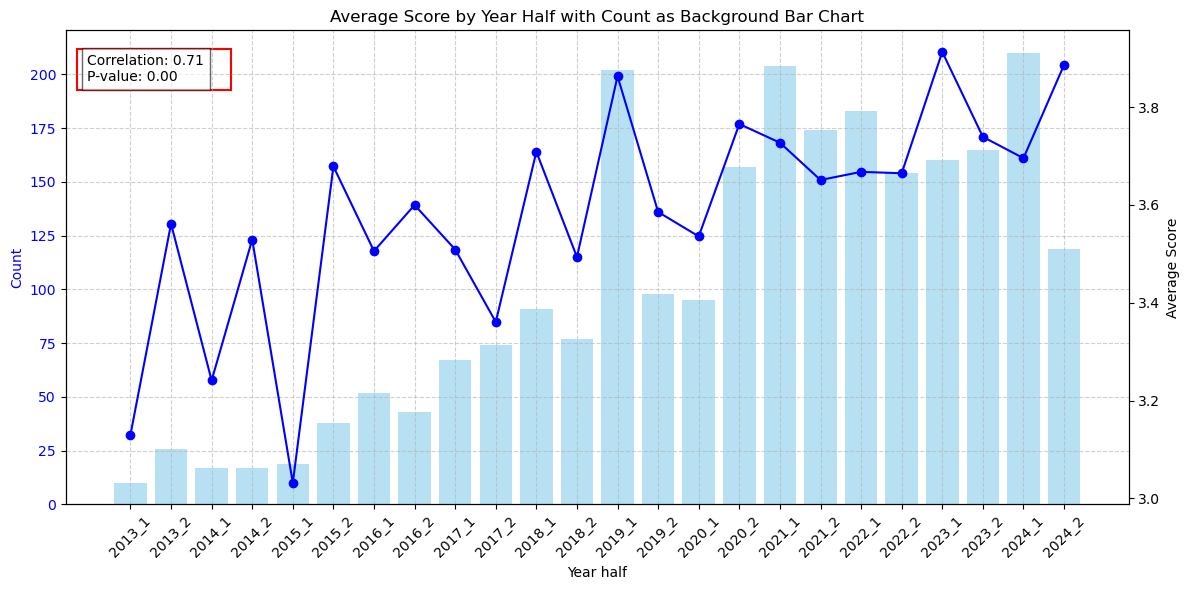

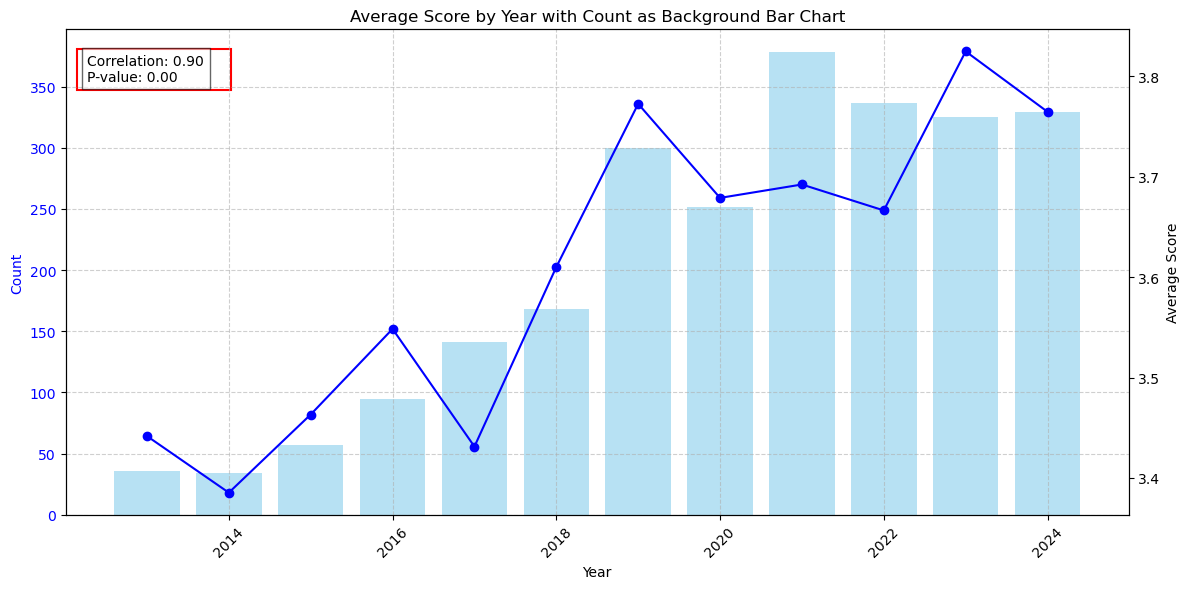

In [14]:
# looking at the data in a time series fashion
create_plot('year_half', 'Average Score by Year Half with Count as Background Bar Chart', combined_data)
create_plot('year', 'Average Score by Year with Count as Background Bar Chart', combined_data)


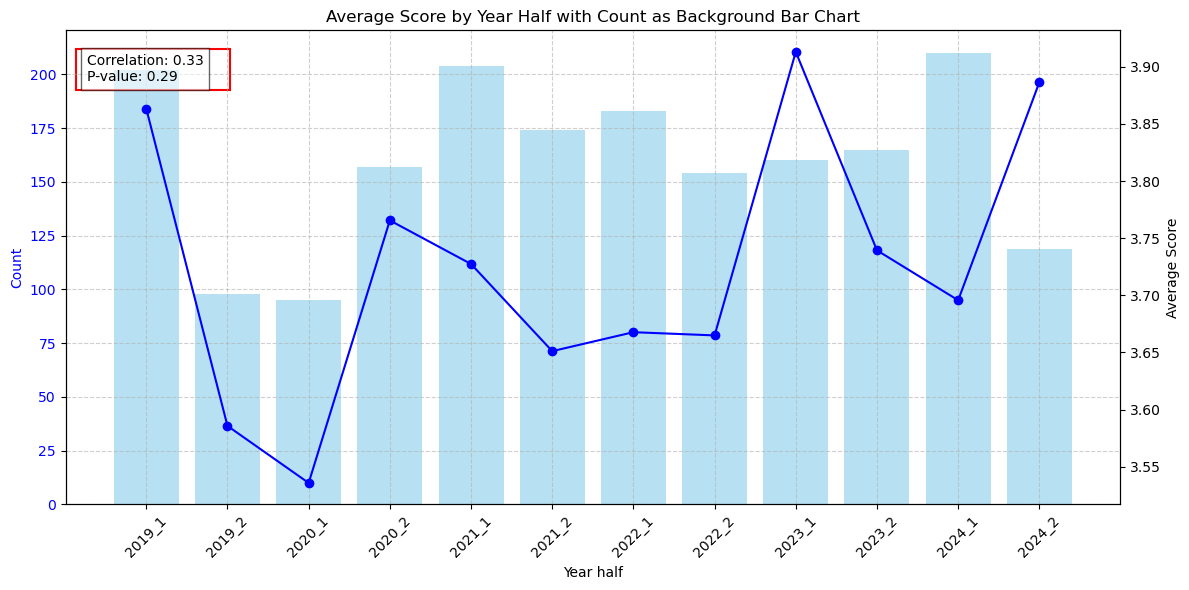

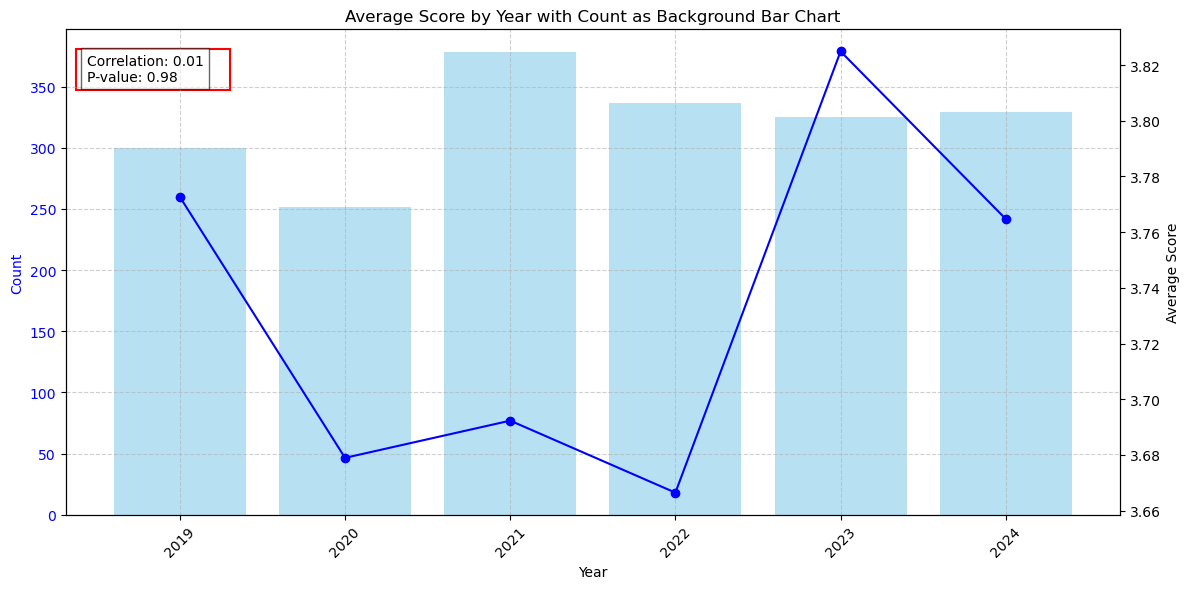

In [15]:
# based on the corrletation we will look at data after 2019
combined_data_2 = combined_data[combined_data['parsed_date'].dt.year>=2019]

create_plot('year_half', 'Average Score by Year Half with Count as Background Bar Chart', combined_data_2)
create_plot('year', 'Average Score by Year with Count as Background Bar Chart', combined_data_2)


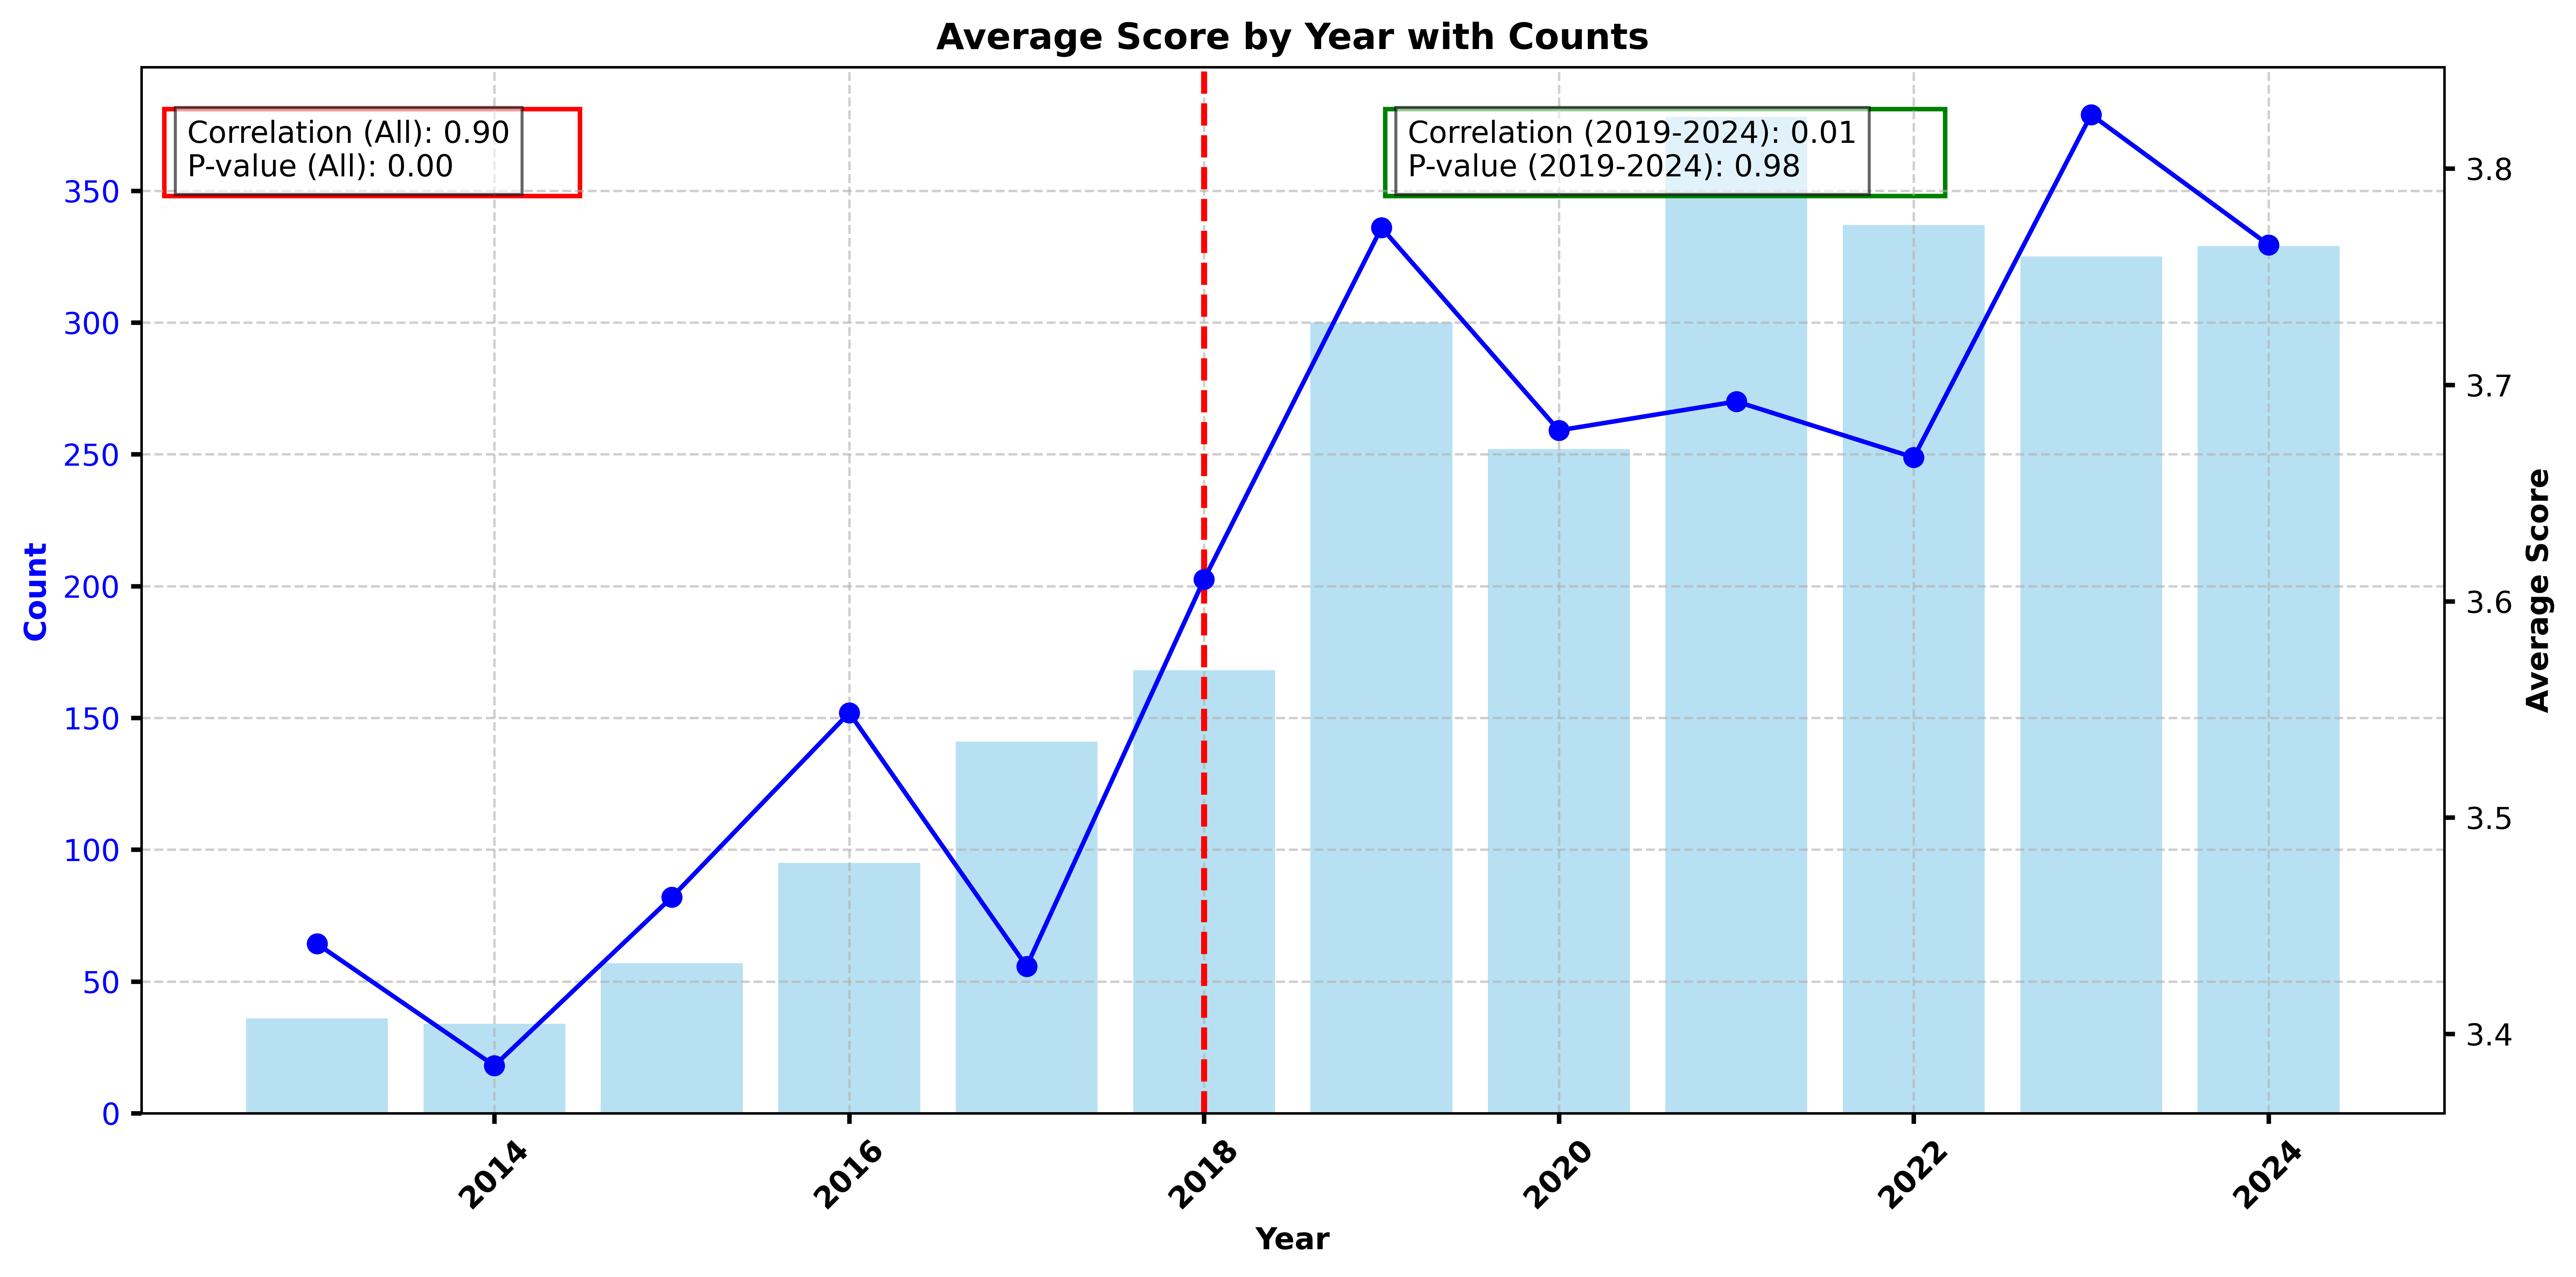

In [16]:
create_double_plot('year', 'Average Score by Year with Counts', combined_data)

### looking at All data VS Germany 

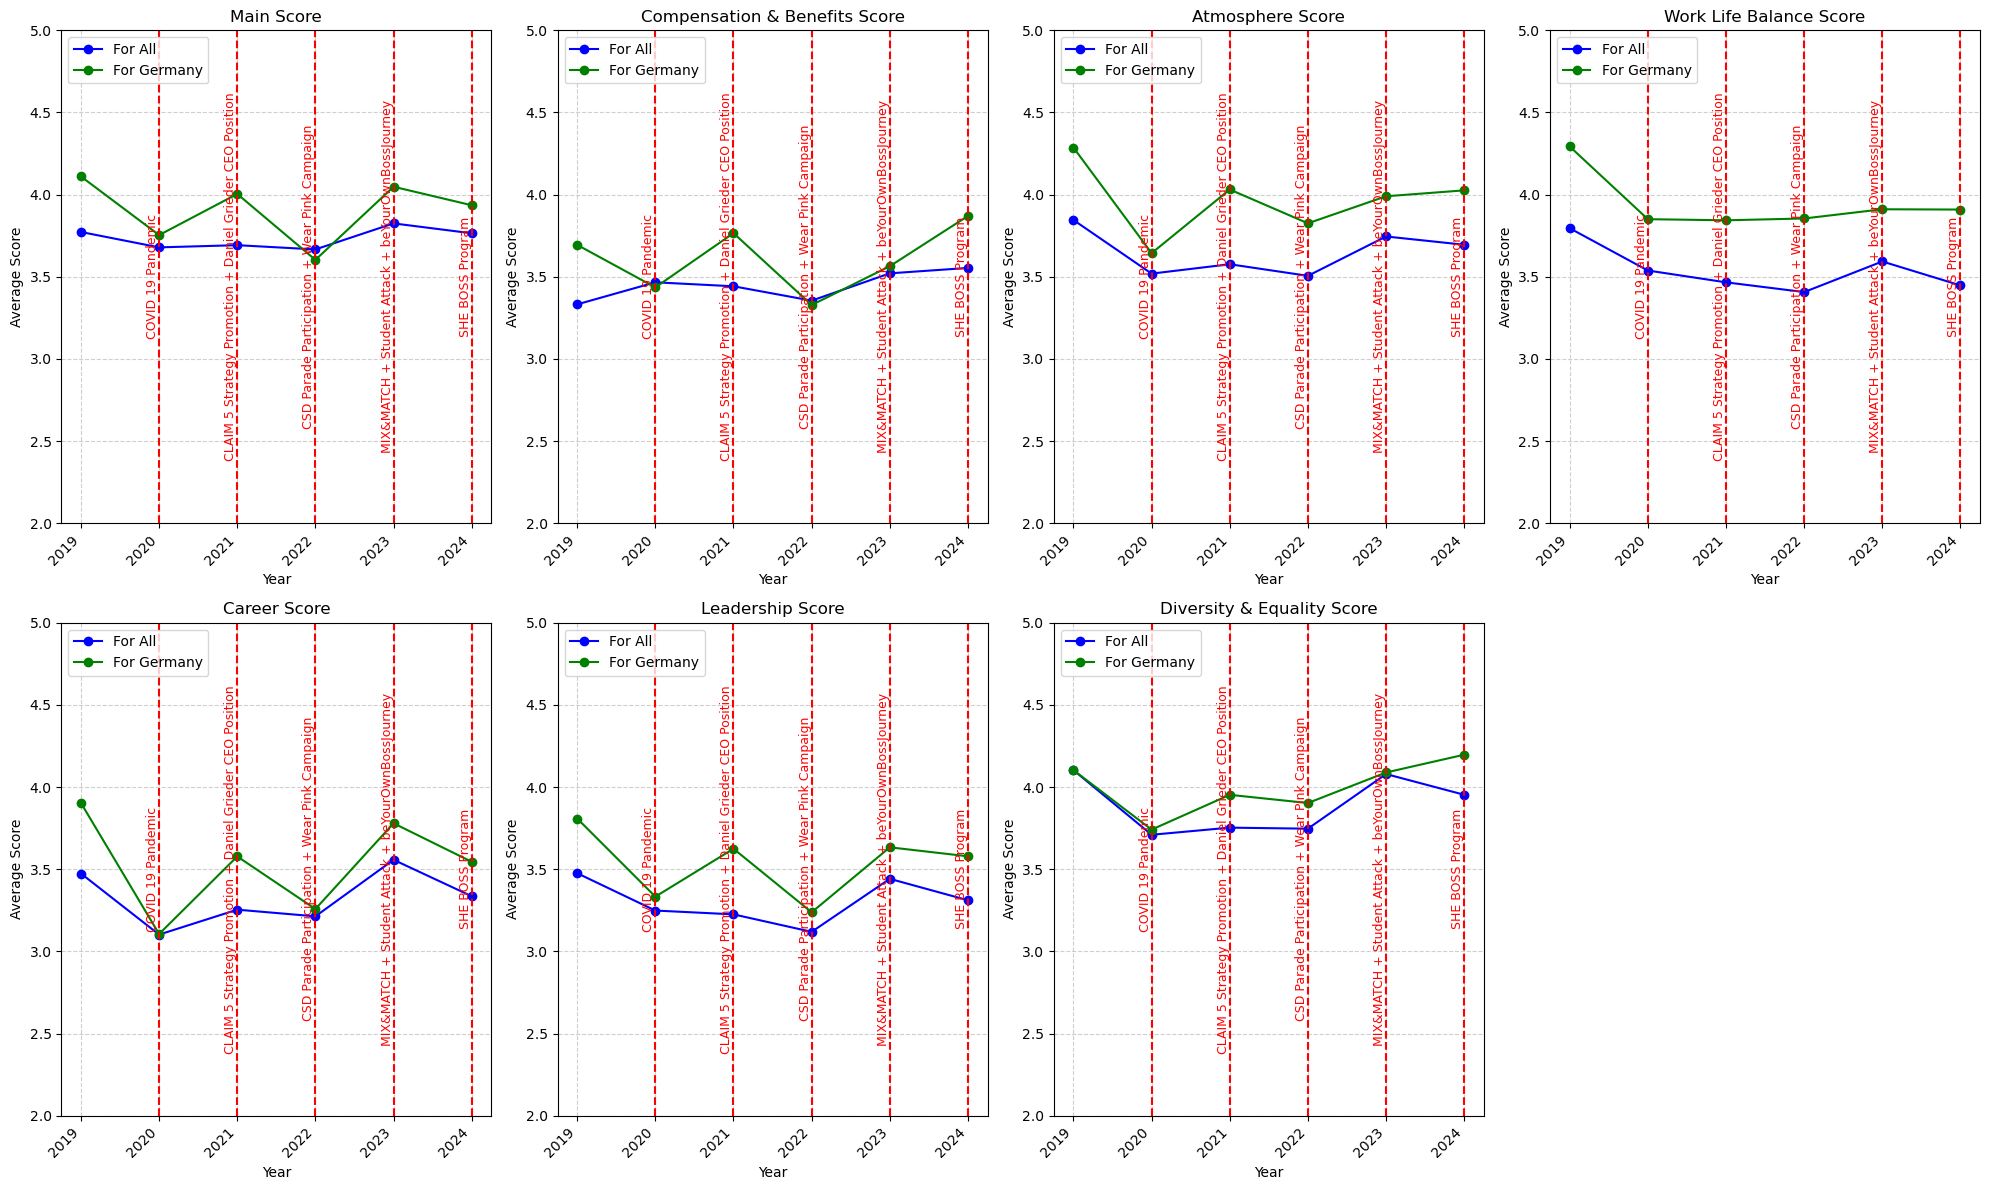

In [17]:
score_columns = [
'Main Score', 'Compensation & Benefits Score', 'Atmosphere Score', 'Work Life Balance Score', 'Career Score', 'Leadership Score', 'Diversity & Equality Score'
]

n_cols = 4
n_rows = (len(score_columns) + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows), constrained_layout=True)
axes = axes.flatten()

data_2 = combined_data_2[combined_data_2['country'] == 'Germany']
data_1 = combined_data_2
data_2_label = 'For Germany'
data_1_label = 'For All'
for ax, column in zip(axes, score_columns):
    create_year_subplot(ax, 'year', f'{column}', column, data_1, data_2, data_1_label, data_2_label, score_columns)
    add_campaign_lines_with_combined_labels(ax, campaigns_halfs)

for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


In [18]:
# Lets See which Time series show significant change over the years country-wise
# We will only see Germany VS All countries as it makes more sense

Anova_test_years(combined_data_2, 'All Countries')
Anova_test_years(combined_data_2[combined_data_2['country'] == 'Germany'], 'Germany')

Germans_percantage = round(len(combined_data_2[combined_data_2['country'] == 'Germany']) / len(combined_data_2), 2)
print('Germanys Percentage of the data :', Germans_percantage)


For All Countries :
No significant difference in Main Score across years (p-value: 0.469)
No significant difference in Compensation & Benefits Score across years (p-value: 0.239)
significant difference in Atmosphere Score across years (p-value: 0.026)
significant difference in Work Life Balance Score across years (p-value: 0.009)
significant difference in Career Score across years (p-value: 0.002)
significant difference in Leadership Score across years (p-value: 0.040)
significant difference in Diversity & Equality Score across years (p-value: 0.001)
For Germany :
significant difference in Main Score across years (p-value: 0.003)
significant difference in Compensation & Benefits Score across years (p-value: 0.026)
significant difference in Atmosphere Score across years (p-value: 0.003)
significant difference in Work Life Balance Score across years (p-value: 0.008)
significant difference in Career Score across years (p-value: 0.000)
significant difference in Leadership Score across year

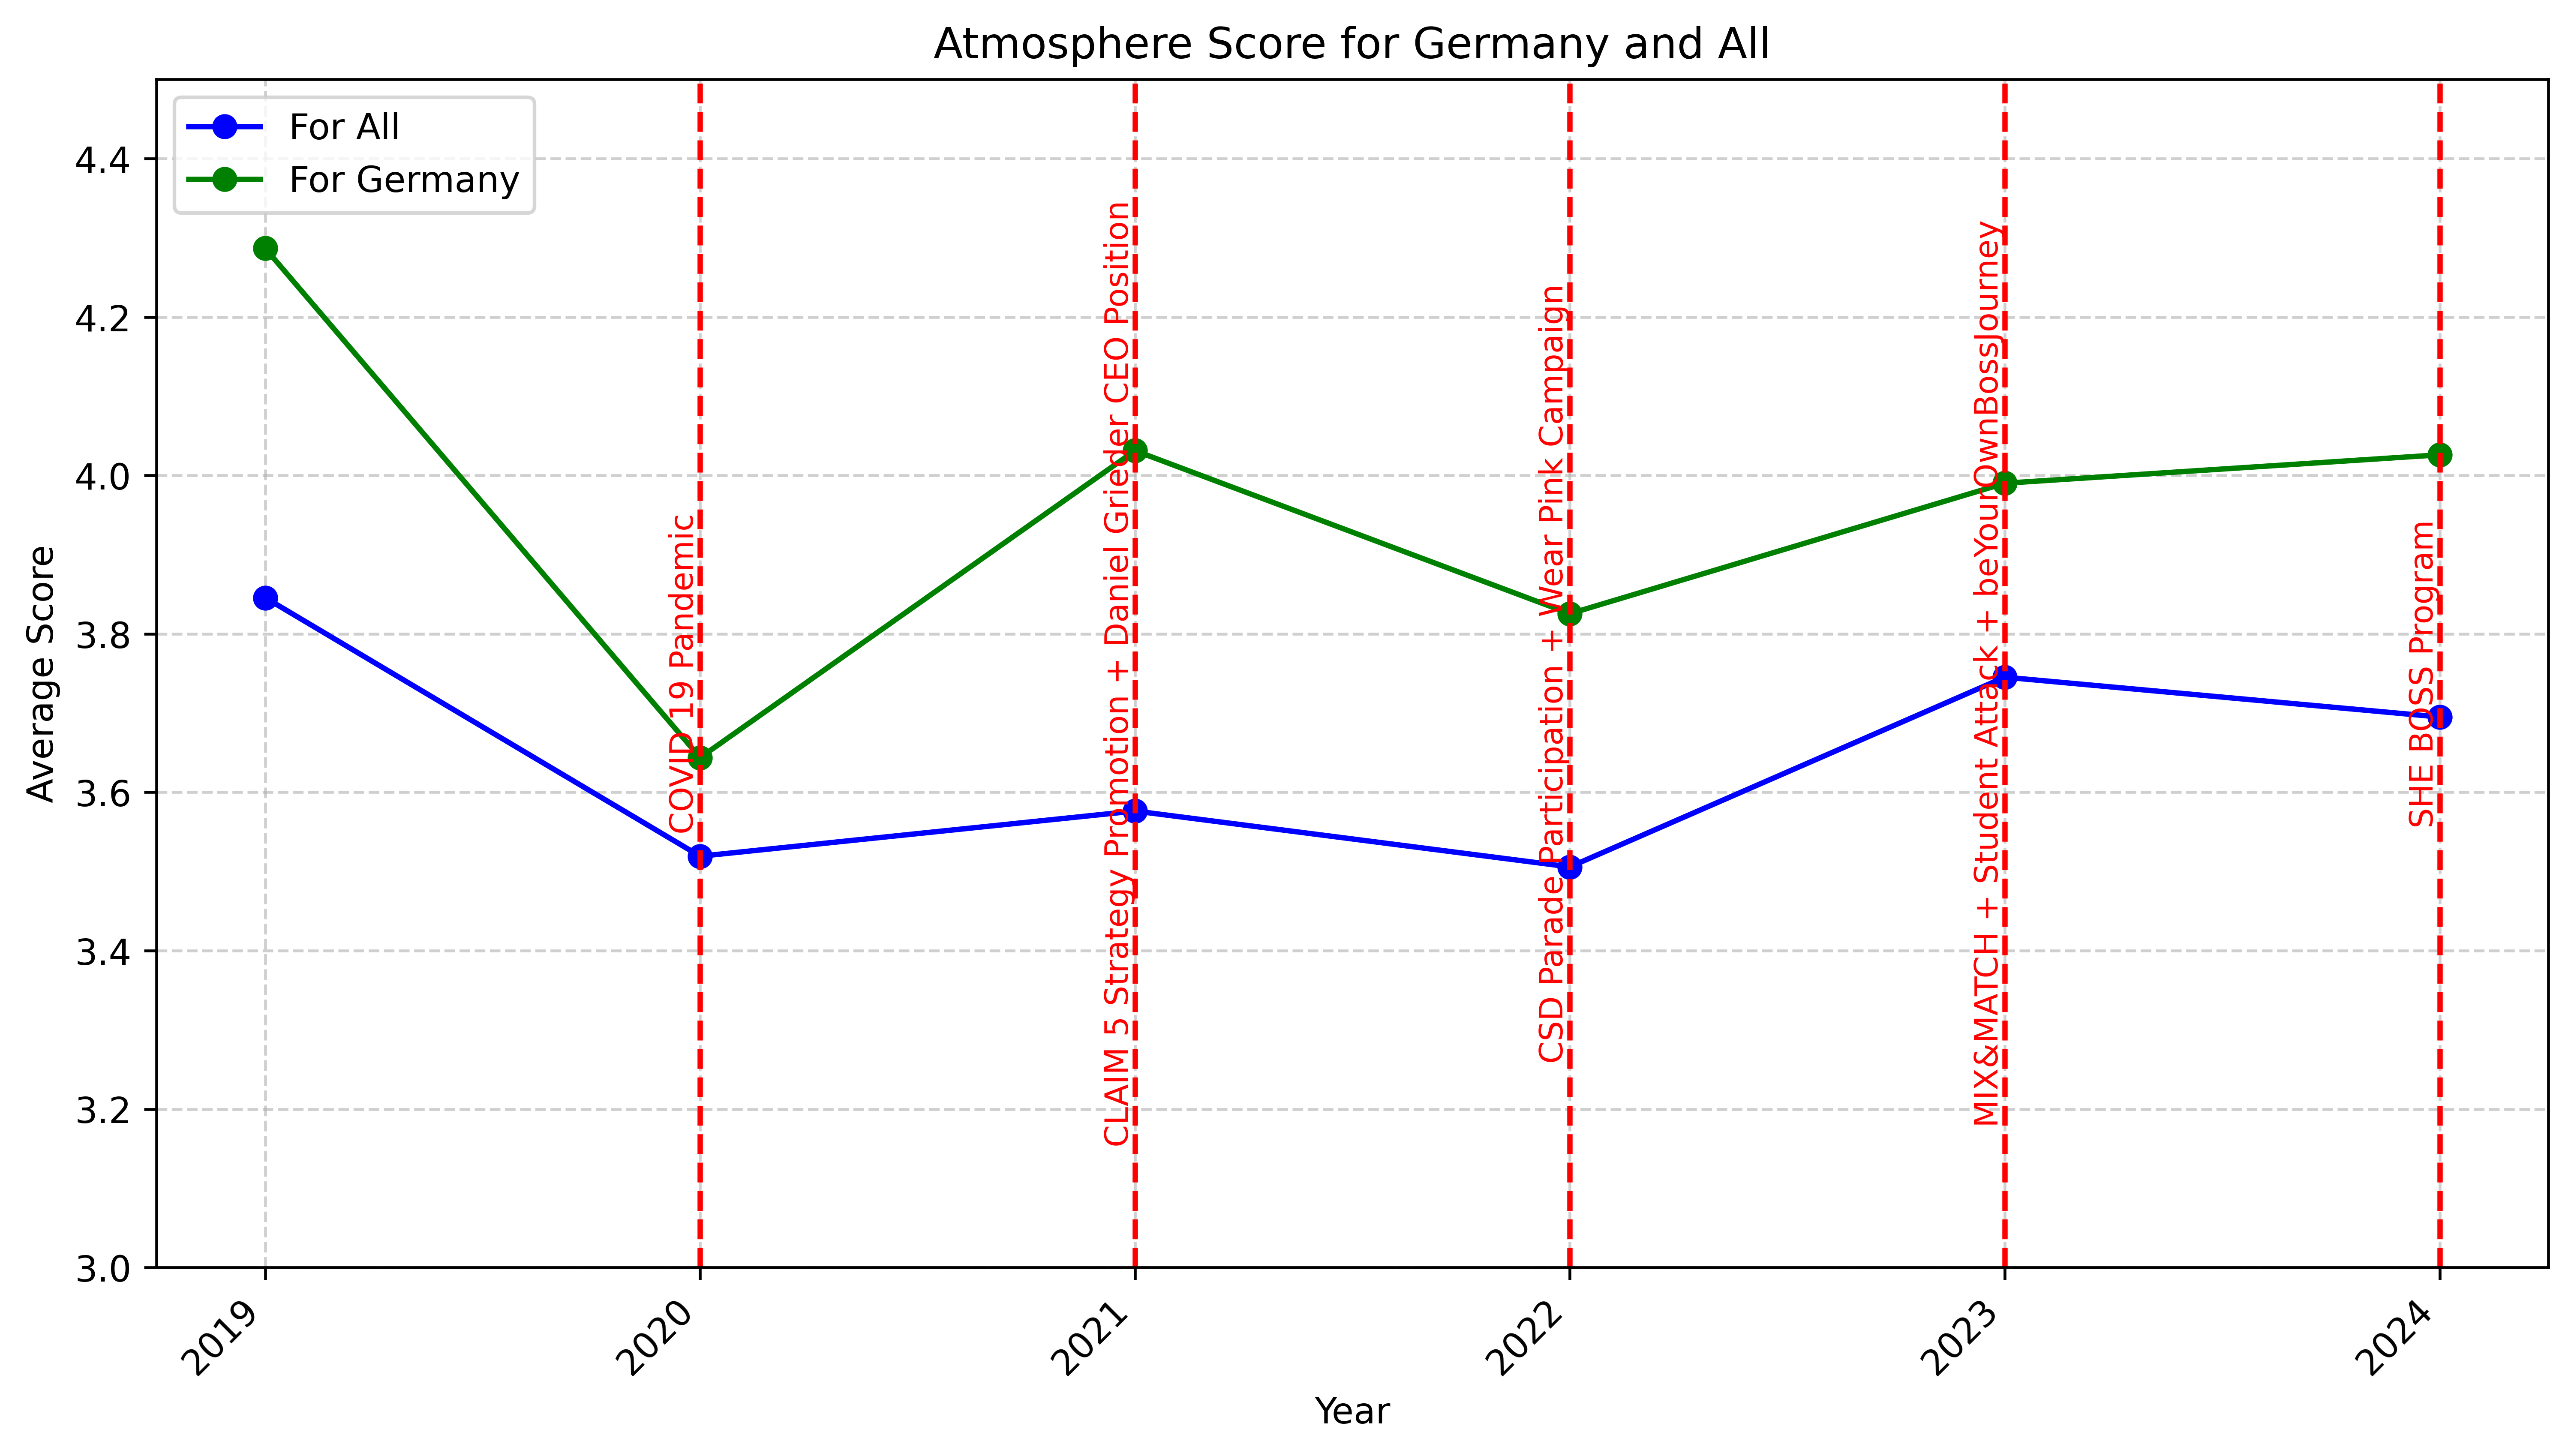

In [19]:
# Atmosphere Score
# p-value germany : 0.003 , p-value All : 0.026
data_2 = combined_data_2[combined_data_2['country'] == 'Germany']
data_1 = combined_data_2
data_2_label = 'For Germany'
data_1_label = 'For All'

create_single_plot('year', 'Atmosphere Score for Germany and All', 'Atmosphere Score', data_1, data_2, data_1_label, data_2_label, campaigns_halfs,3,4.5)


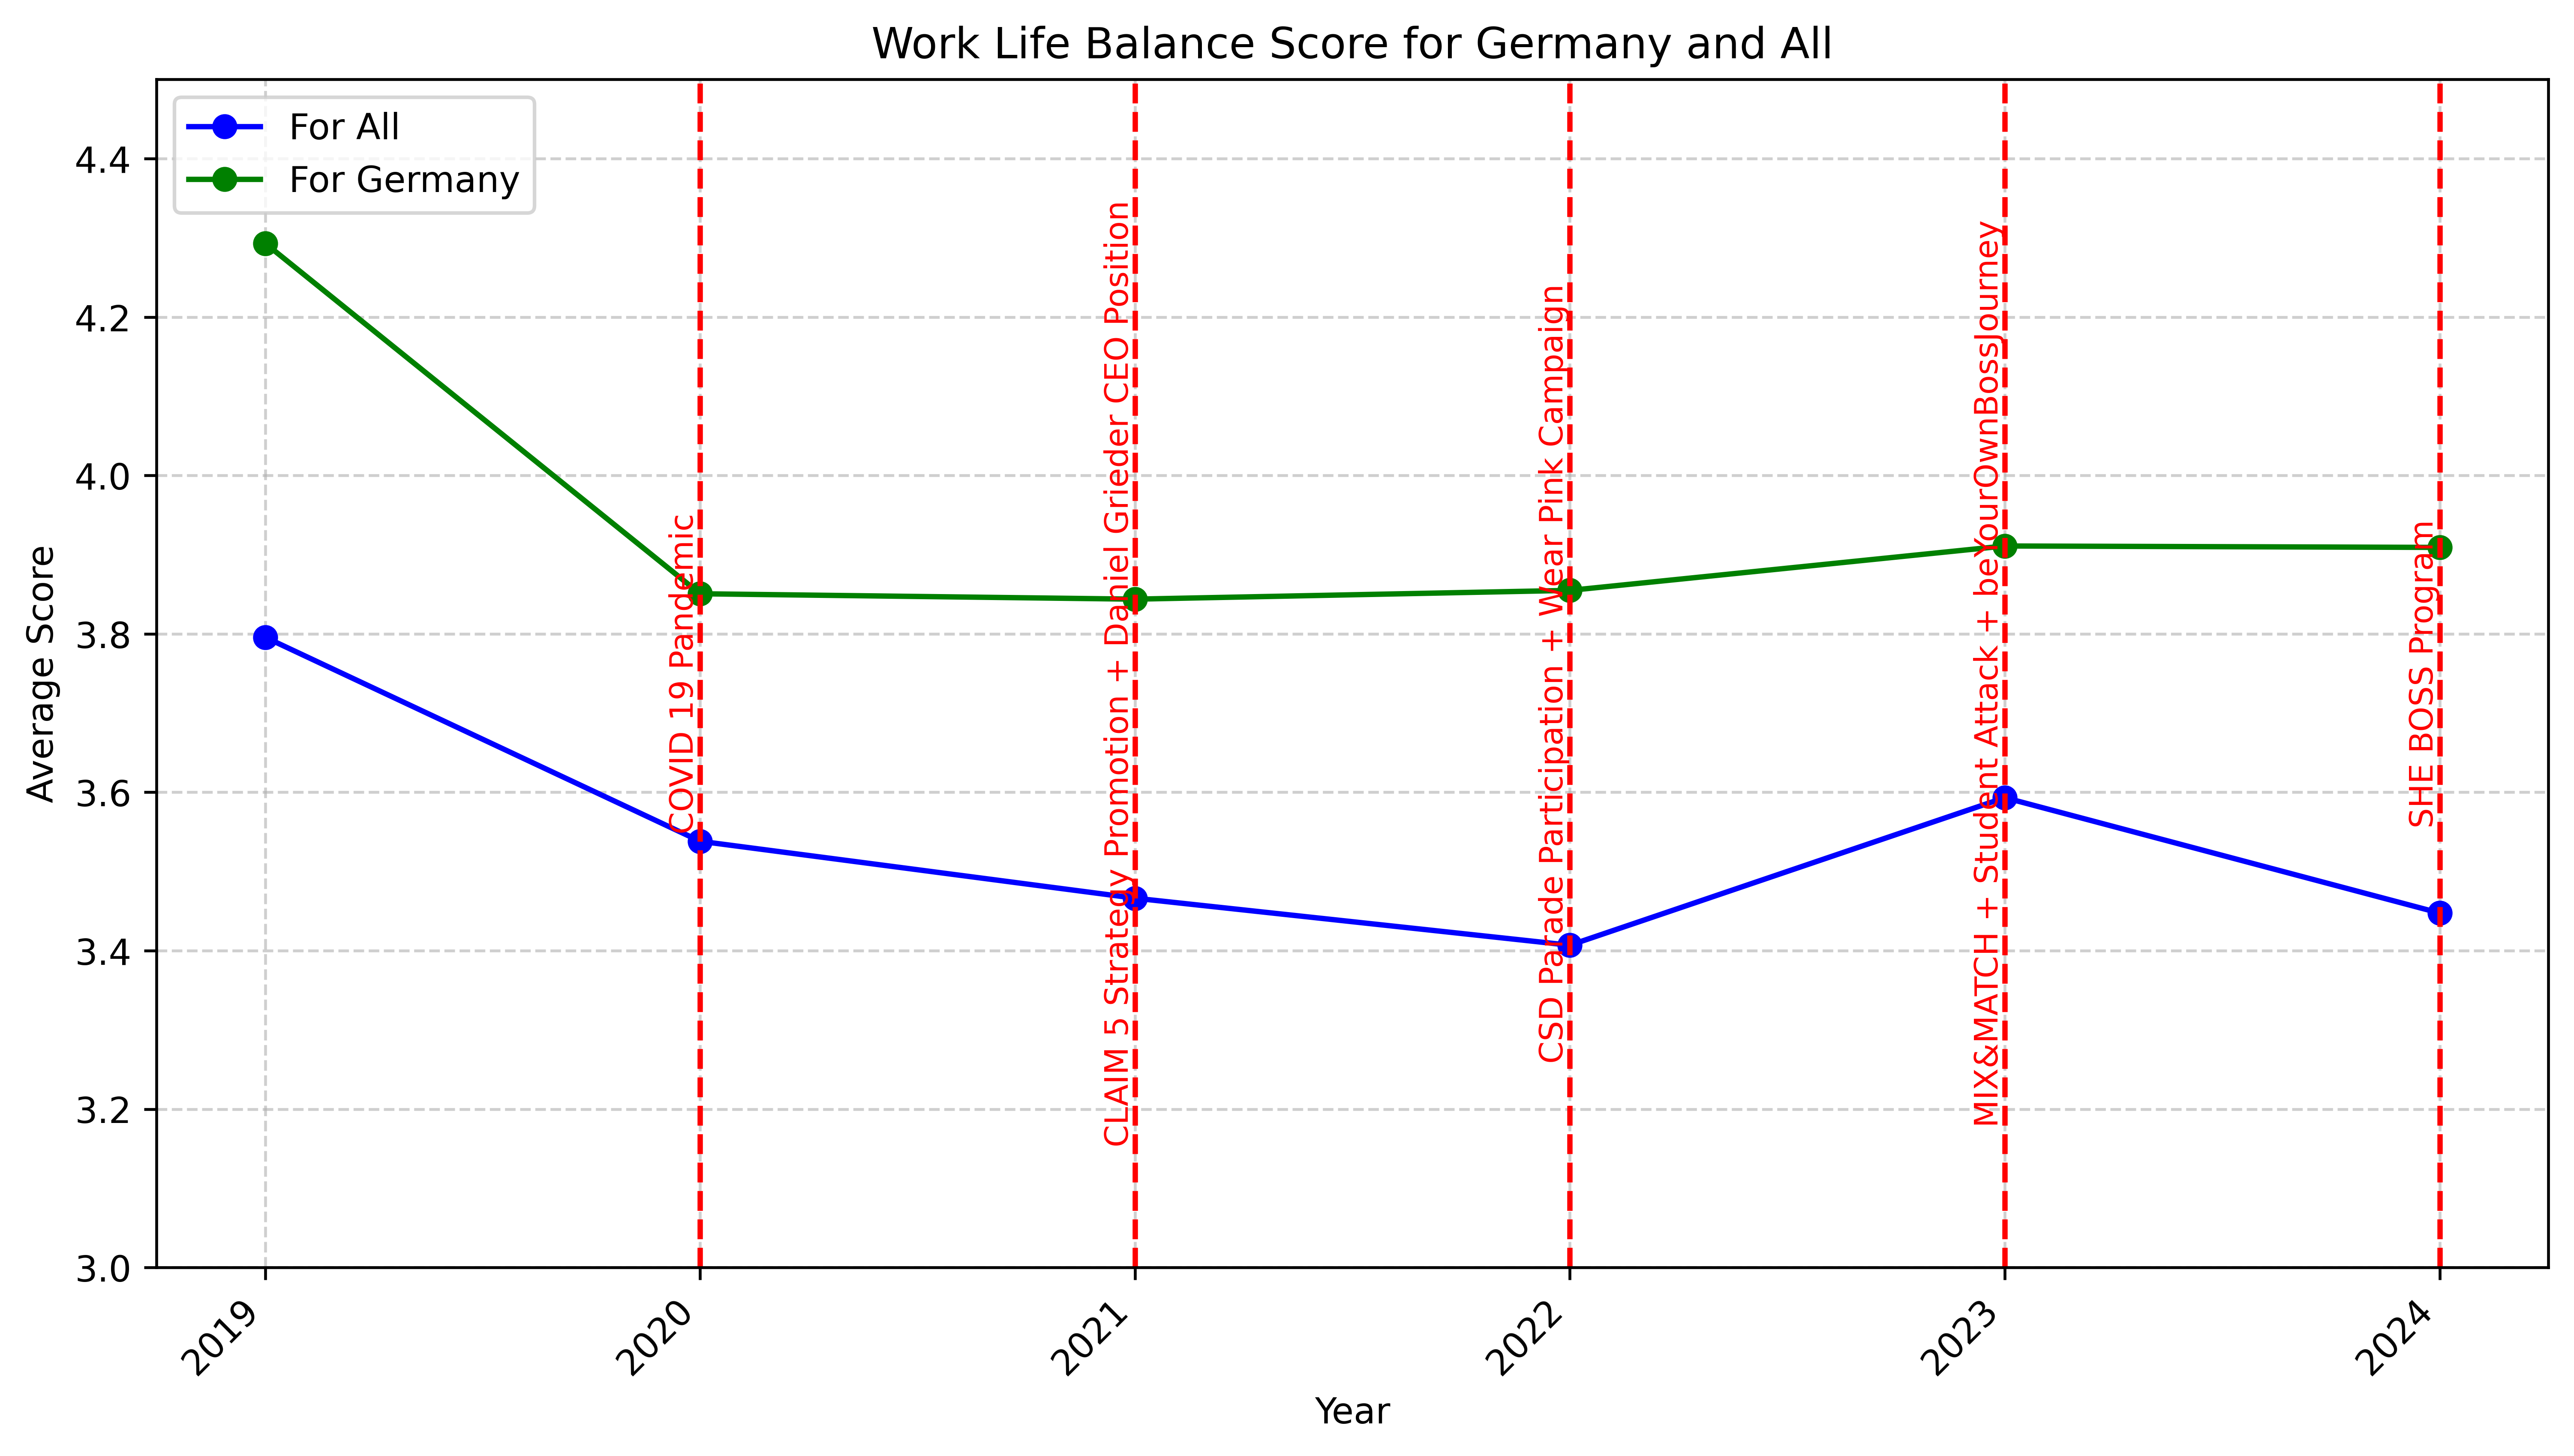

In [20]:
# Work Life Balance Score
# p-value germany : 0.008 , p-value All : 0.009
data_2 = combined_data_2[combined_data_2['country'] == 'Germany']
data_1 = combined_data_2
data_2_label = 'For Germany'
data_1_label = 'For All'

create_single_plot('year', 'Work Life Balance Score for Germany and All', 'Work Life Balance Score', data_1, data_2, data_1_label, data_2_label, campaigns_halfs,3,4.5)


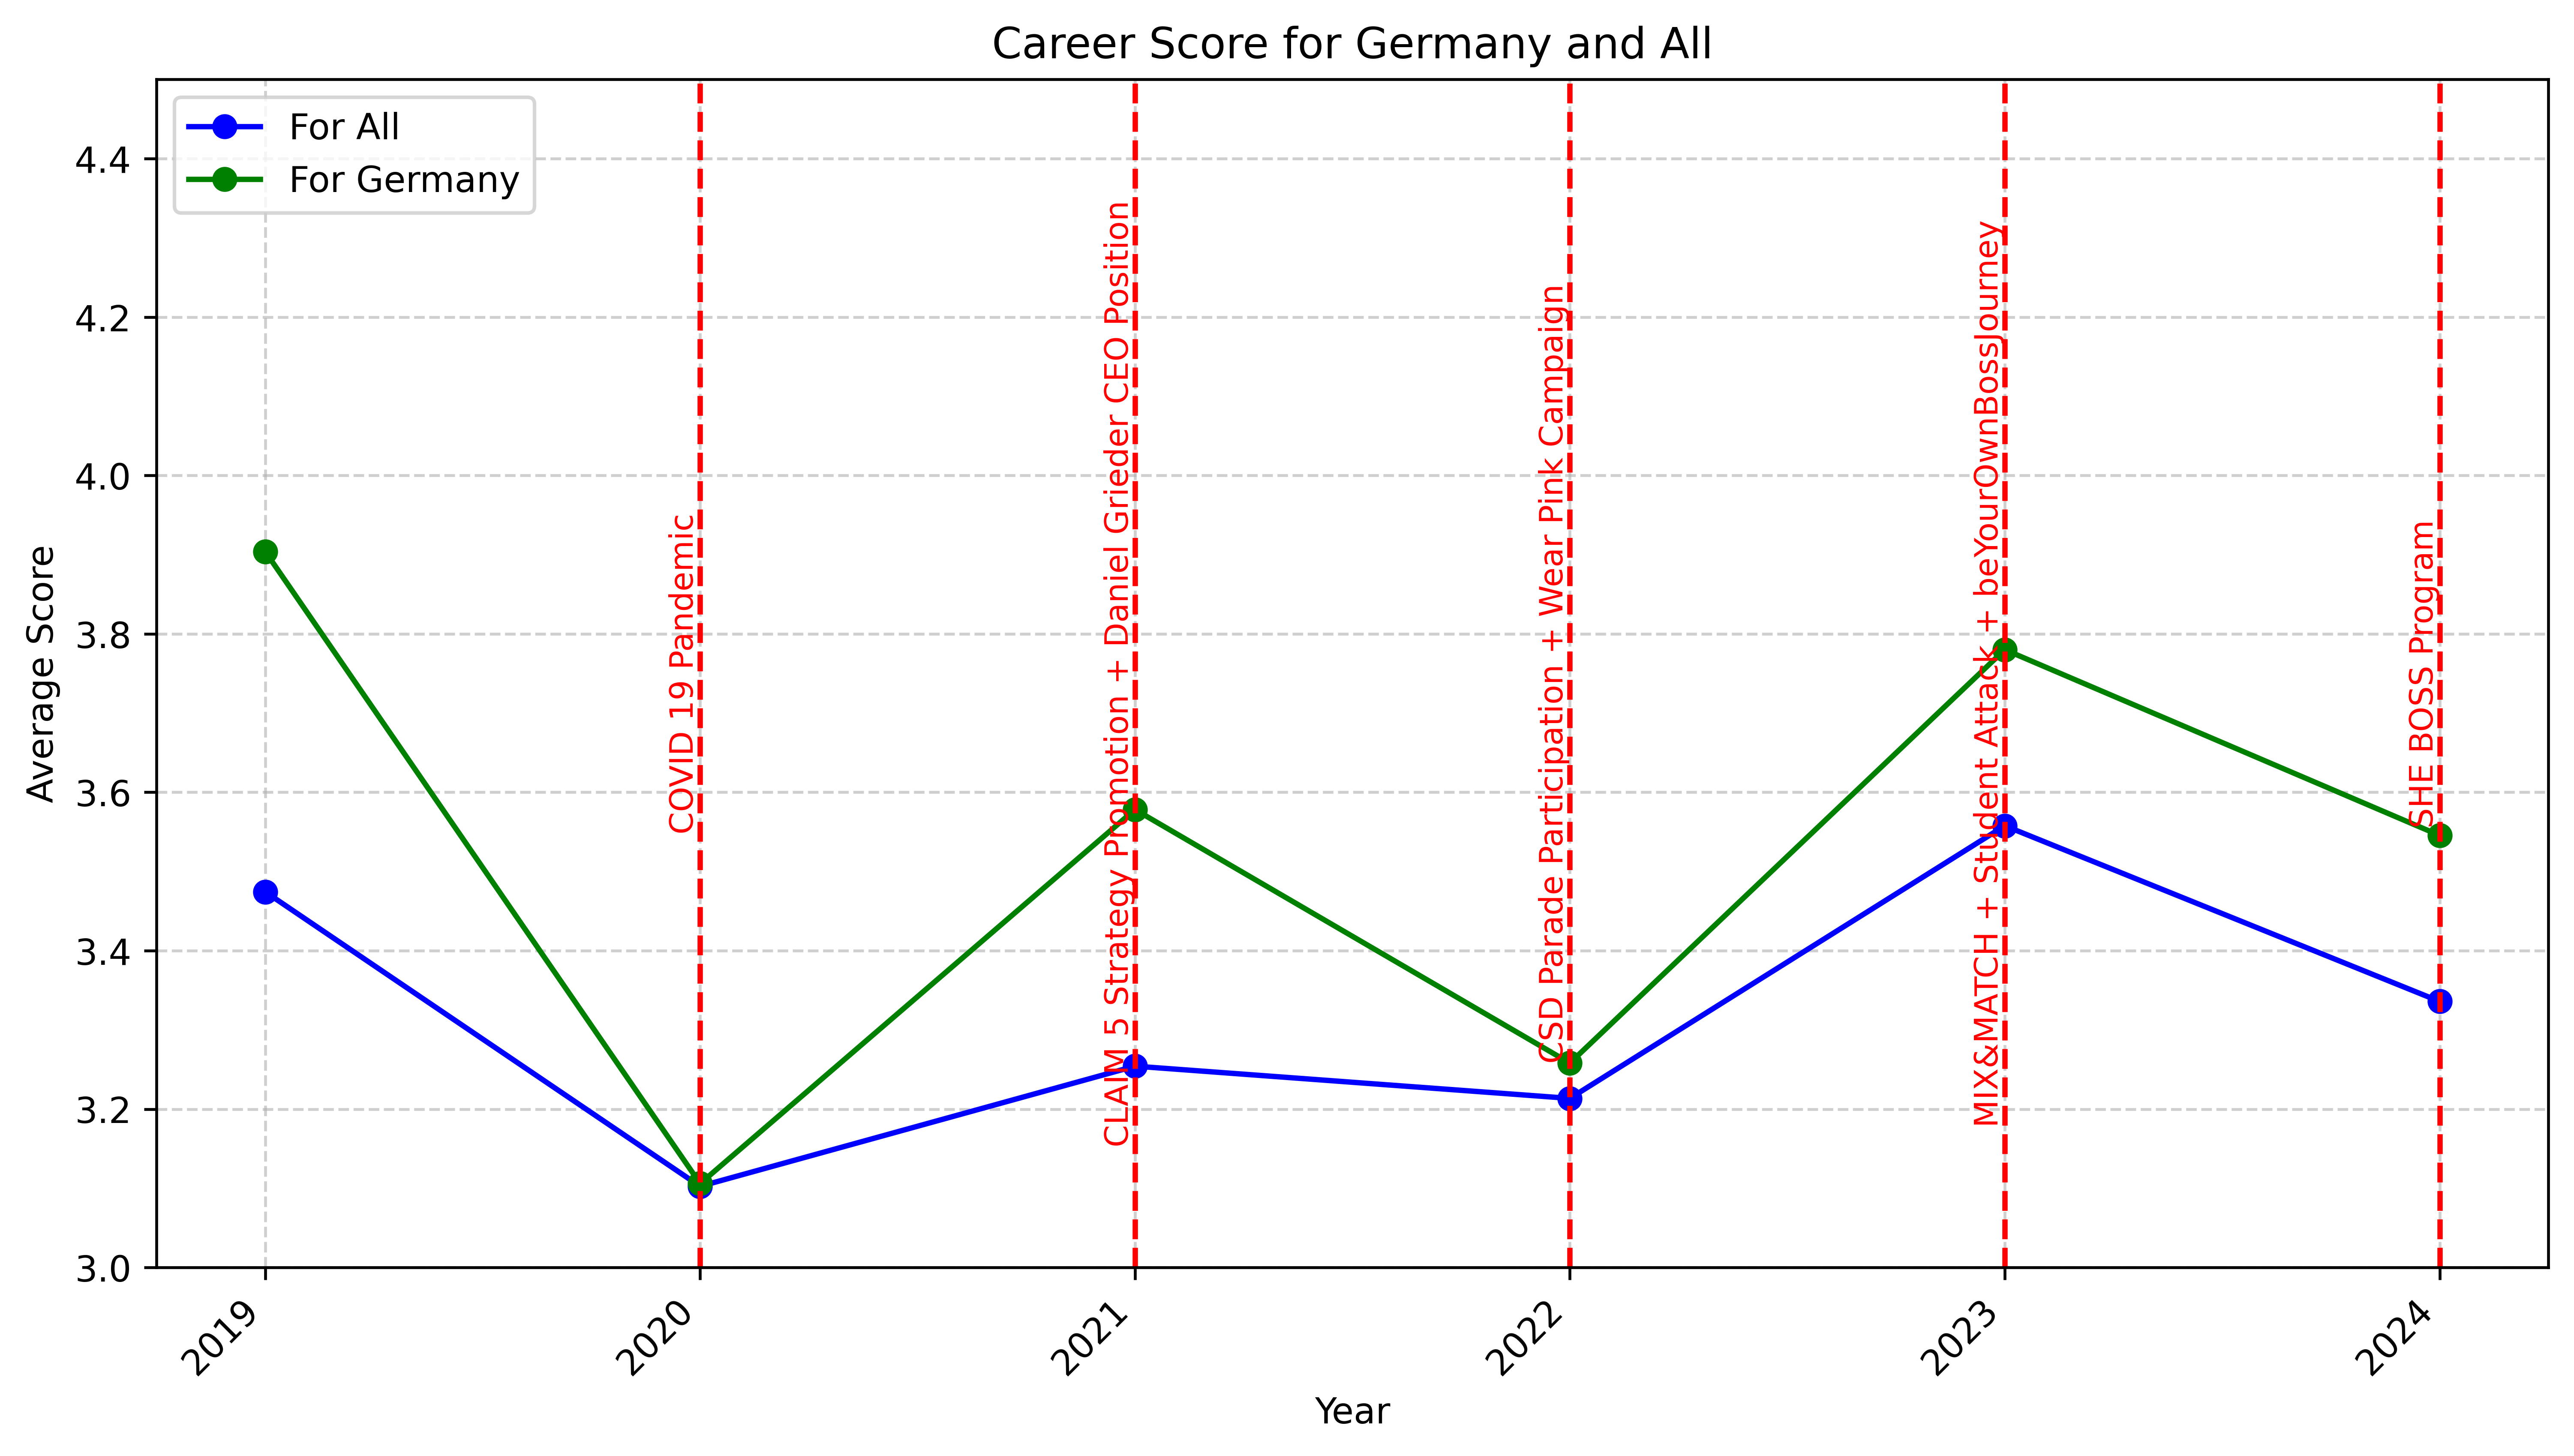

In [21]:
# Career Score
# p-value germany : 0.000 , p-value All : 0.002
data_2 = combined_data_2[combined_data_2['country'] == 'Germany']
data_1 = combined_data_2
data_2_label = 'For Germany'
data_1_label = 'For All'

create_single_plot('year', 'Career Score for Germany and All', 'Career Score', data_1, data_2, data_1_label, data_2_label, campaigns_halfs,3,4.5)


**Atmosphere Score:**
- Both global and German scores dipped in 2020, potentially due to the onset of the COVID-19 pandemic, which might have impacted workplace conditions negatively.
- Recovery starts in 2021, potentially because of the CEO change.

**Work Life Balance Score:**
- There is a significant drop in 2020 for the global average, less so for Germany. The drop aligns with the pandemic, suggesting disruptions in work-life balance due to new working conditions (like remote work and lockdowns).
- The trend after 2020 doesn't show any improvement.

**Career Score:**
- A notable dip in 2020 for the global score, with a slight improvement in 2021 but another drop in 2023. For Germany, the recovery in 2021 is more pronounced.
- The events seem to have a lagged effect with the scores rebounding in the subsequent year (The CEO change).

### General Conclusions
- Something bad is happening in 2022
- for the named Scores that CEO change seem to have an effect on should be checked
- campaigns obviously had effect on Diversity and equlity and Leadership.
- **Germany Shows Greater Resilience**: Despite experiencing more volatility, Germany generally reports higher scores than the global average across all categories. This could reflect more effective local management strategies or cultural factors that contribute to quicker recoveries.
- **Pandemic Impact**: The COVID-19 pandemic in 2020 significantly influenced all scores negatively, reflecting the global challenge faced by organizations in maintaining employee satisfaction and effective management during crises.
- **Delayed Effects of Initiatives**: Several initiatives seem to have a delayed impact on the scores, with improvements often noticeable the year following their introduction, suggesting that the effects of strategic decisions and campaigns on organizational metrics might not be immediate.
- **Event-Score Correlation**: The introduction of specific campaigns and programs, particularly in Germany, correlates with improvements in specific scores (like Diversity and Equality), pointing to the effectiveness of targeted initiatives.


### Checking the significancy of difference before and after CEO change :

In [22]:
#  doing the Mann-whitney test to see if CEO change had a significant impact on the scores we saw relevant

def cliffs_delta(x, y):
    def rank_beyond(array, value):
        return sum([1 for i in array if i > value]) - sum([1 for i in array if i < value])
    n_x, n_y = len(x), len(y)
    delta = sum(rank_beyond(y, i) for i in x)
    return delta / (n_x * n_y)

date_intervals = [
    {'start_date': 2019, 'end_date': 2024},
    {'start_date': 2020, 'end_date': 2022},
    {'start_date': 2019, 'end_date': 2023}
]

for score_column in ['Career Score', 'Atmosphere Score']:
    print(score_column, ':')
    for dates in date_intervals:
        print(f"Date interval: {dates}")

        check_data = combined_data_2.copy()
        check_data['cleaned_date'] = pd.to_datetime(check_data['cleaned_date'])

        check_data = check_data[(check_data['cleaned_date'].dt.year >= dates['start_date']) & (check_data['cleaned_date'].dt.year <= dates['end_date'])]
        
        print(f"Data length for interval: {len(check_data)}")

        # Define the cutoff date for the CEO change
        ceo_change_date = '2021-07-01'


        check_data['post_ceo_change'] = (check_data['cleaned_date'] >= ceo_change_date).astype(int)

        pre_change_scores = check_data[check_data['post_ceo_change'] == 0][score_column].dropna()
        post_change_scores = check_data[check_data['post_ceo_change'] == 1][score_column].dropna()

        # Check if there's enough data in both groups to proceed with the Mann-Whitney U test
        if len(pre_change_scores) > 0 and len(post_change_scores) > 0:
            stat, p_value = mannwhitneyu(pre_change_scores, post_change_scores, alternative='two-sided')
            print(f"Mann-Whitney U statistic: {stat}, P-value: {p_value}")

            # Calculate Cliff's Delta
            # should be clos to 1 or -1 to show significancy
            delta = cliffs_delta(pre_change_scores, post_change_scores)
            print('delta :', delta)
       


Career Score :
Date interval: {'start_date': 2019, 'end_date': 2024}
Data length for interval: 1921
Mann-Whitney U statistic: 289911.0, P-value: 0.5092339238961441
delta : 0.019139419693606885
Date interval: {'start_date': 2020, 'end_date': 2022}
Data length for interval: 967
Mann-Whitney U statistic: 71838.0, P-value: 0.454234732860869
delta : 0.030460894797219785
Date interval: {'start_date': 2019, 'end_date': 2023}
Data length for interval: 1592
Mann-Whitney U statistic: 207416.5, P-value: 0.4777409450739051
delta : 0.022178379321236463
Atmosphere Score :
Date interval: {'start_date': 2019, 'end_date': 2024}
Data length for interval: 1921
Mann-Whitney U statistic: 302205.5, P-value: 0.3072663119380902
delta : -0.02923842170420662
Date interval: {'start_date': 2020, 'end_date': 2022}
Data length for interval: 967
Mann-Whitney U statistic: 74936.5, P-value: 0.4801359160816092
delta : -0.02864810328142266
Date interval: {'start_date': 2019, 'end_date': 2023}
Data length for interval: 1

### Checking the trend of Diversity and equality from the end of 2020 :

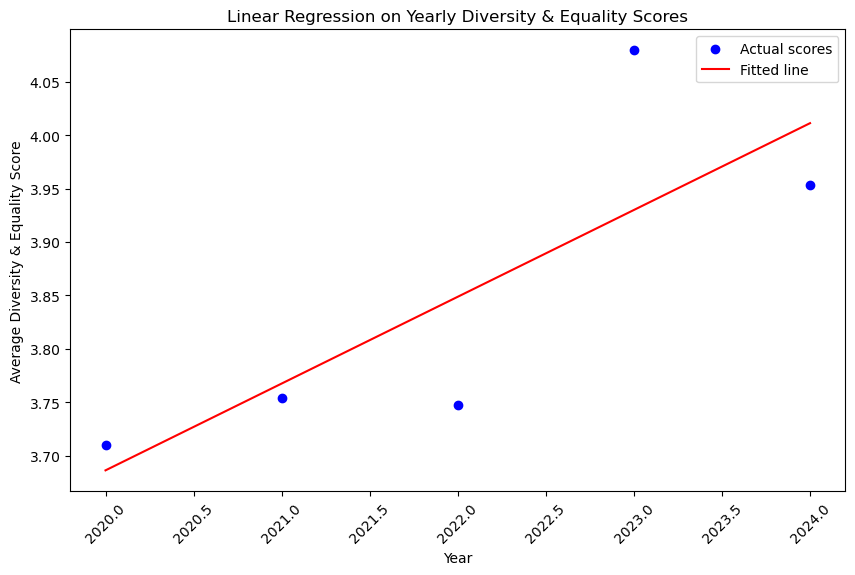

R-squared: 0.64


In [23]:
# Fitting a Linear Regression

data = combined_data_2[combined_data_2['year'] != 2019]
data['cleaned_date'] = pd.to_datetime(data['cleaned_date'], errors='coerce')

data = data.set_index('cleaned_date')

grouped = data.groupby(pd.Grouper(freq='Y'))
yearly_averages = grouped['Diversity & Equality Score'].mean().reset_index()

years = yearly_averages['cleaned_date'].dt.year.to_numpy()
average_scores = yearly_averages['Diversity & Equality Score'].to_numpy()

start_date = years.min()
time_in_years = (years - start_date)

X = np.array(time_in_years).reshape(-1, 1) 
y = average_scores

# Fit the linear regression model
model = LinearRegression().fit(X, y)
predictions = model.predict(X)
r_squared = model.score(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(years, y, color='blue', label='Actual scores')
plt.plot(years, predictions, color='red', label='Fitted line')
plt.title('Linear Regression on Yearly Diversity & Equality Scores')
plt.xlabel('Year')
plt.ylabel('Average Diversity & Equality Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(f'R-squared: {r_squared:.2f}')


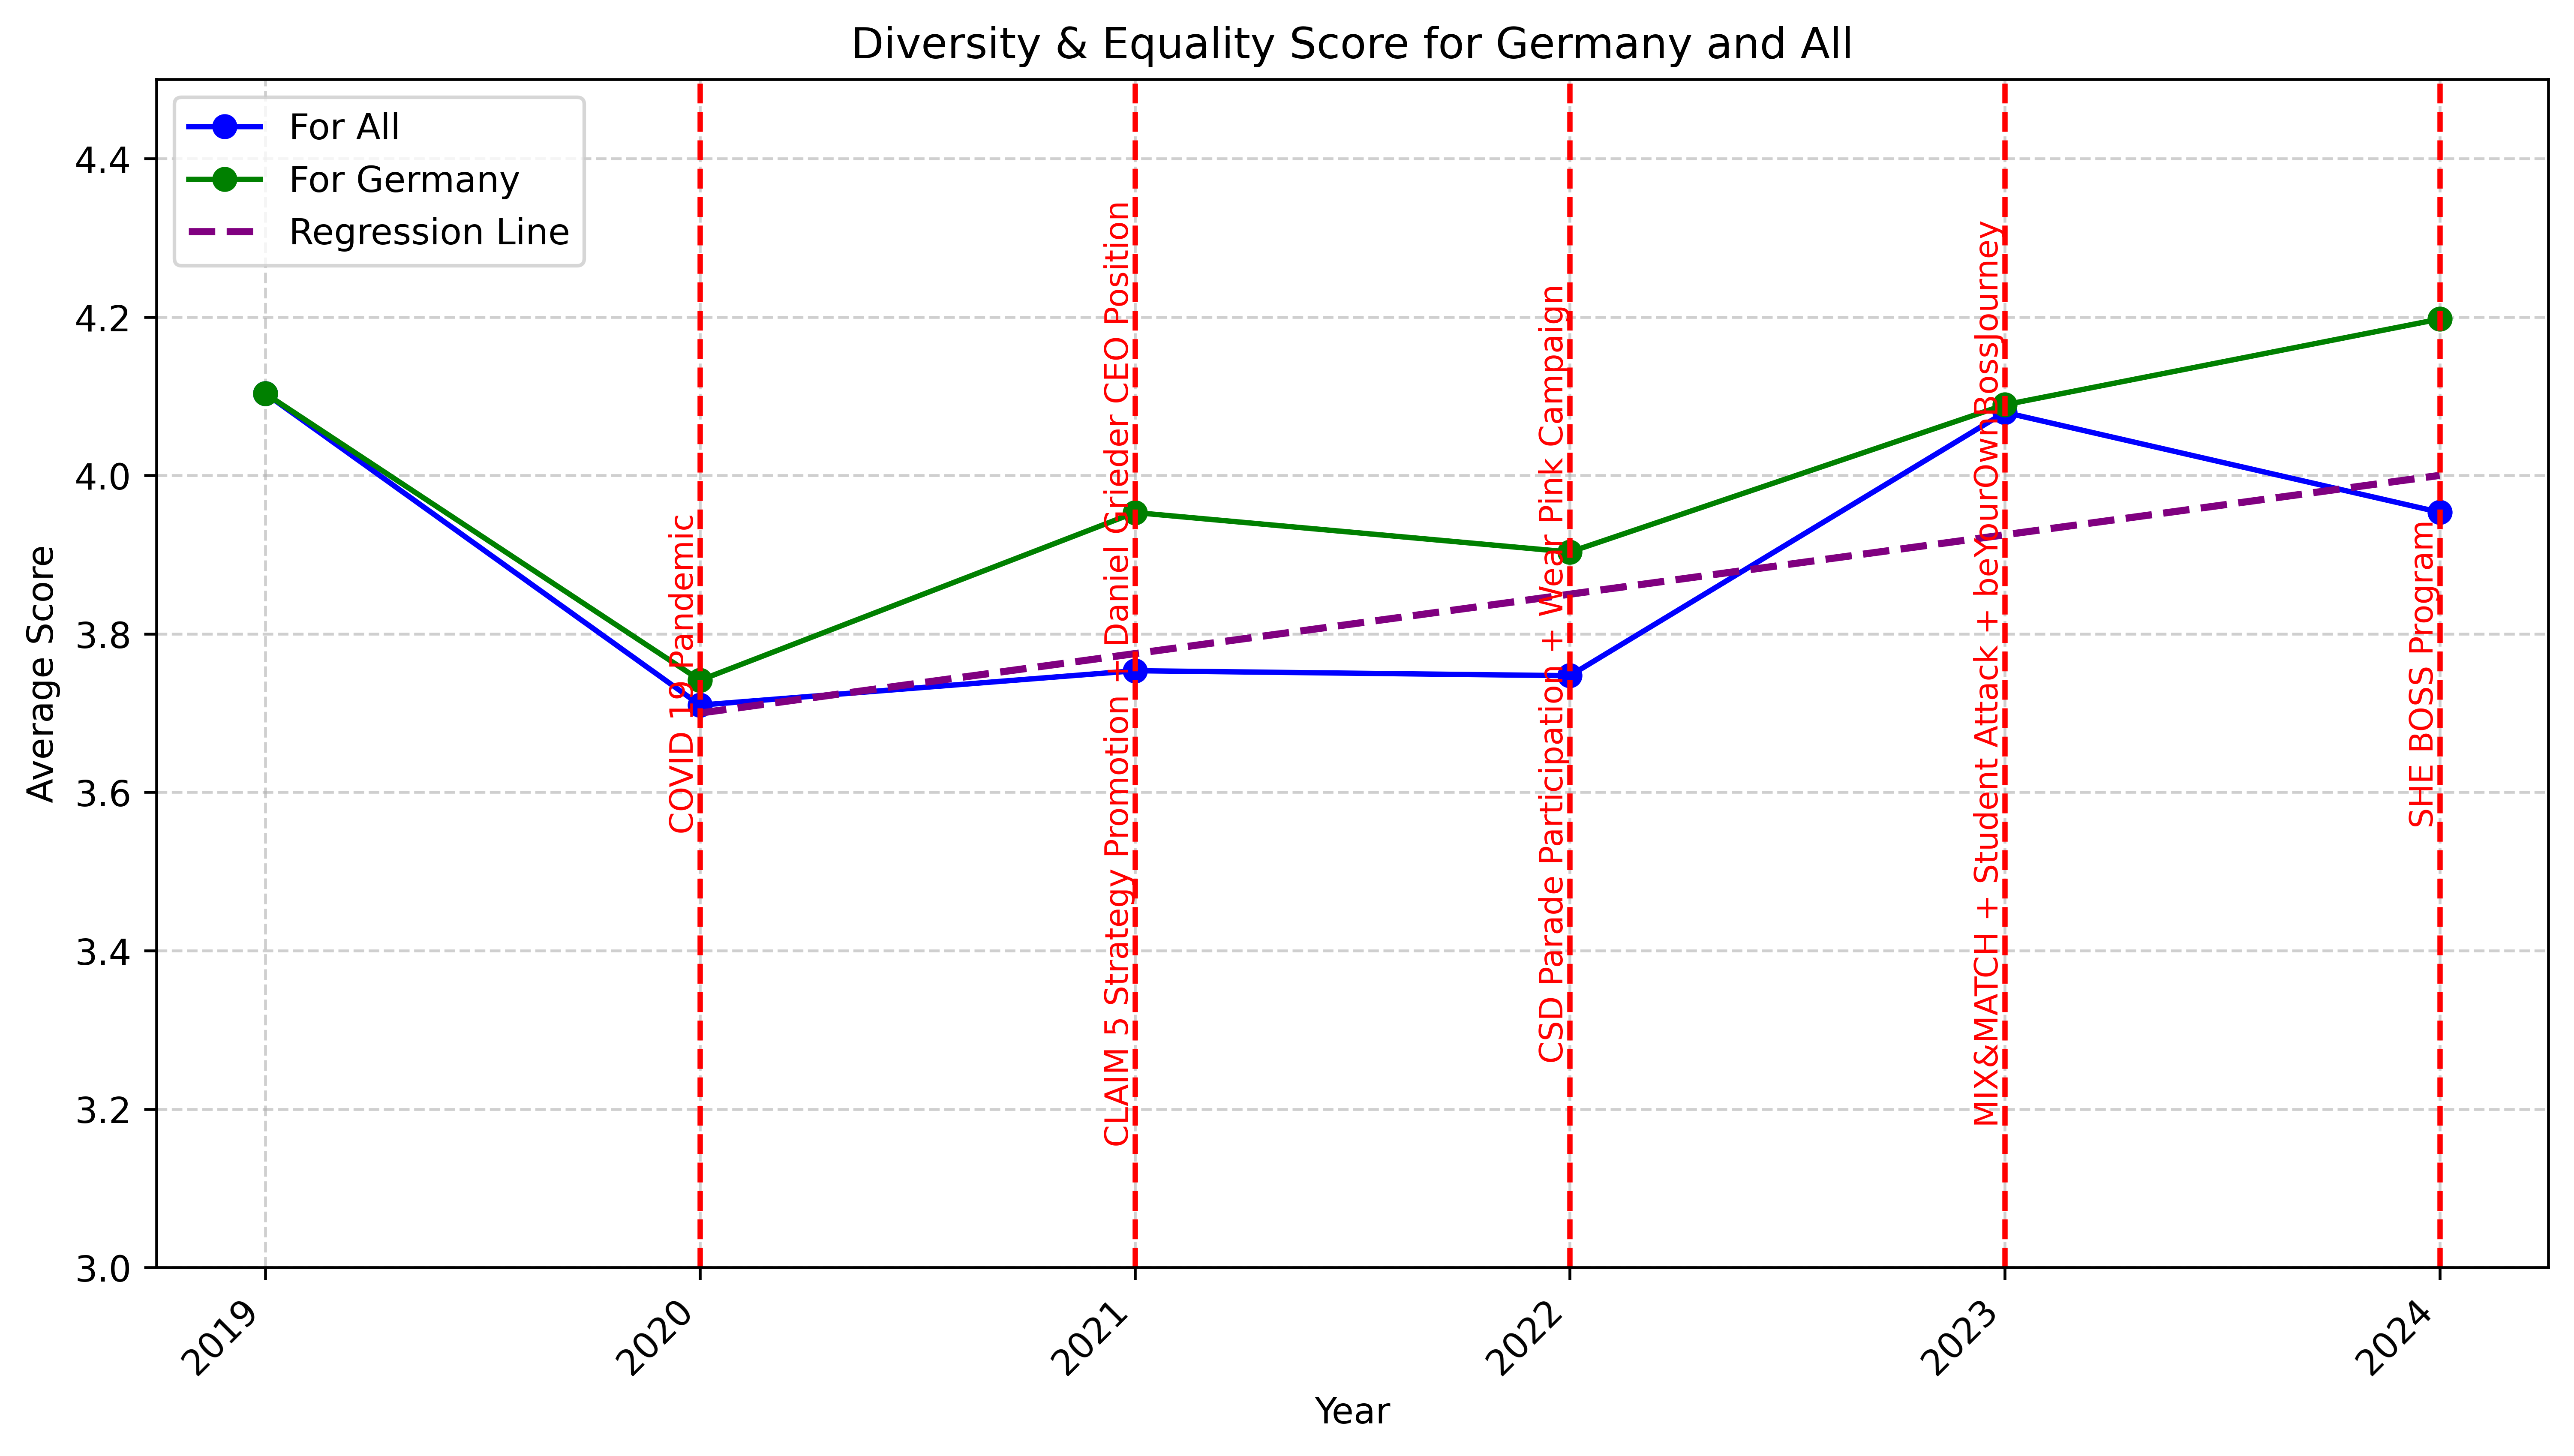

In [24]:
# Diversity & Equality Score with regression line

# the start and end coordinates for the regression line
start_year = 2020
start_score = 3.7
end_year = 2024
end_score = 4.0

# Creating the subplots for each score column with two datasets
# p-value germany : 0.258 , p-value All : 0.001
data_2 = combined_data_2[combined_data_2['country'] == 'Germany']
data_1 = combined_data_2
data_2_label = 'For Germany'
data_1_label = 'For All'

create_single_plot_with_regression('year', 'Diversity & Equality Score for Germany and All', 'Diversity & Equality Score', data_1, data_2, data_1_label, data_2_label, campaigns_halfs,3,4.5, start_year, start_score, end_year, end_score)


### Lets stratify by department in germany and total

In [25]:
# as you can see the Logistic data is too small to see in a time series way
combined_data_2['business_function_department'].value_counts(dropna=False)

Corporate    671
Retail       647
other        529
Logistics     74
Name: business_function_department, dtype: int64

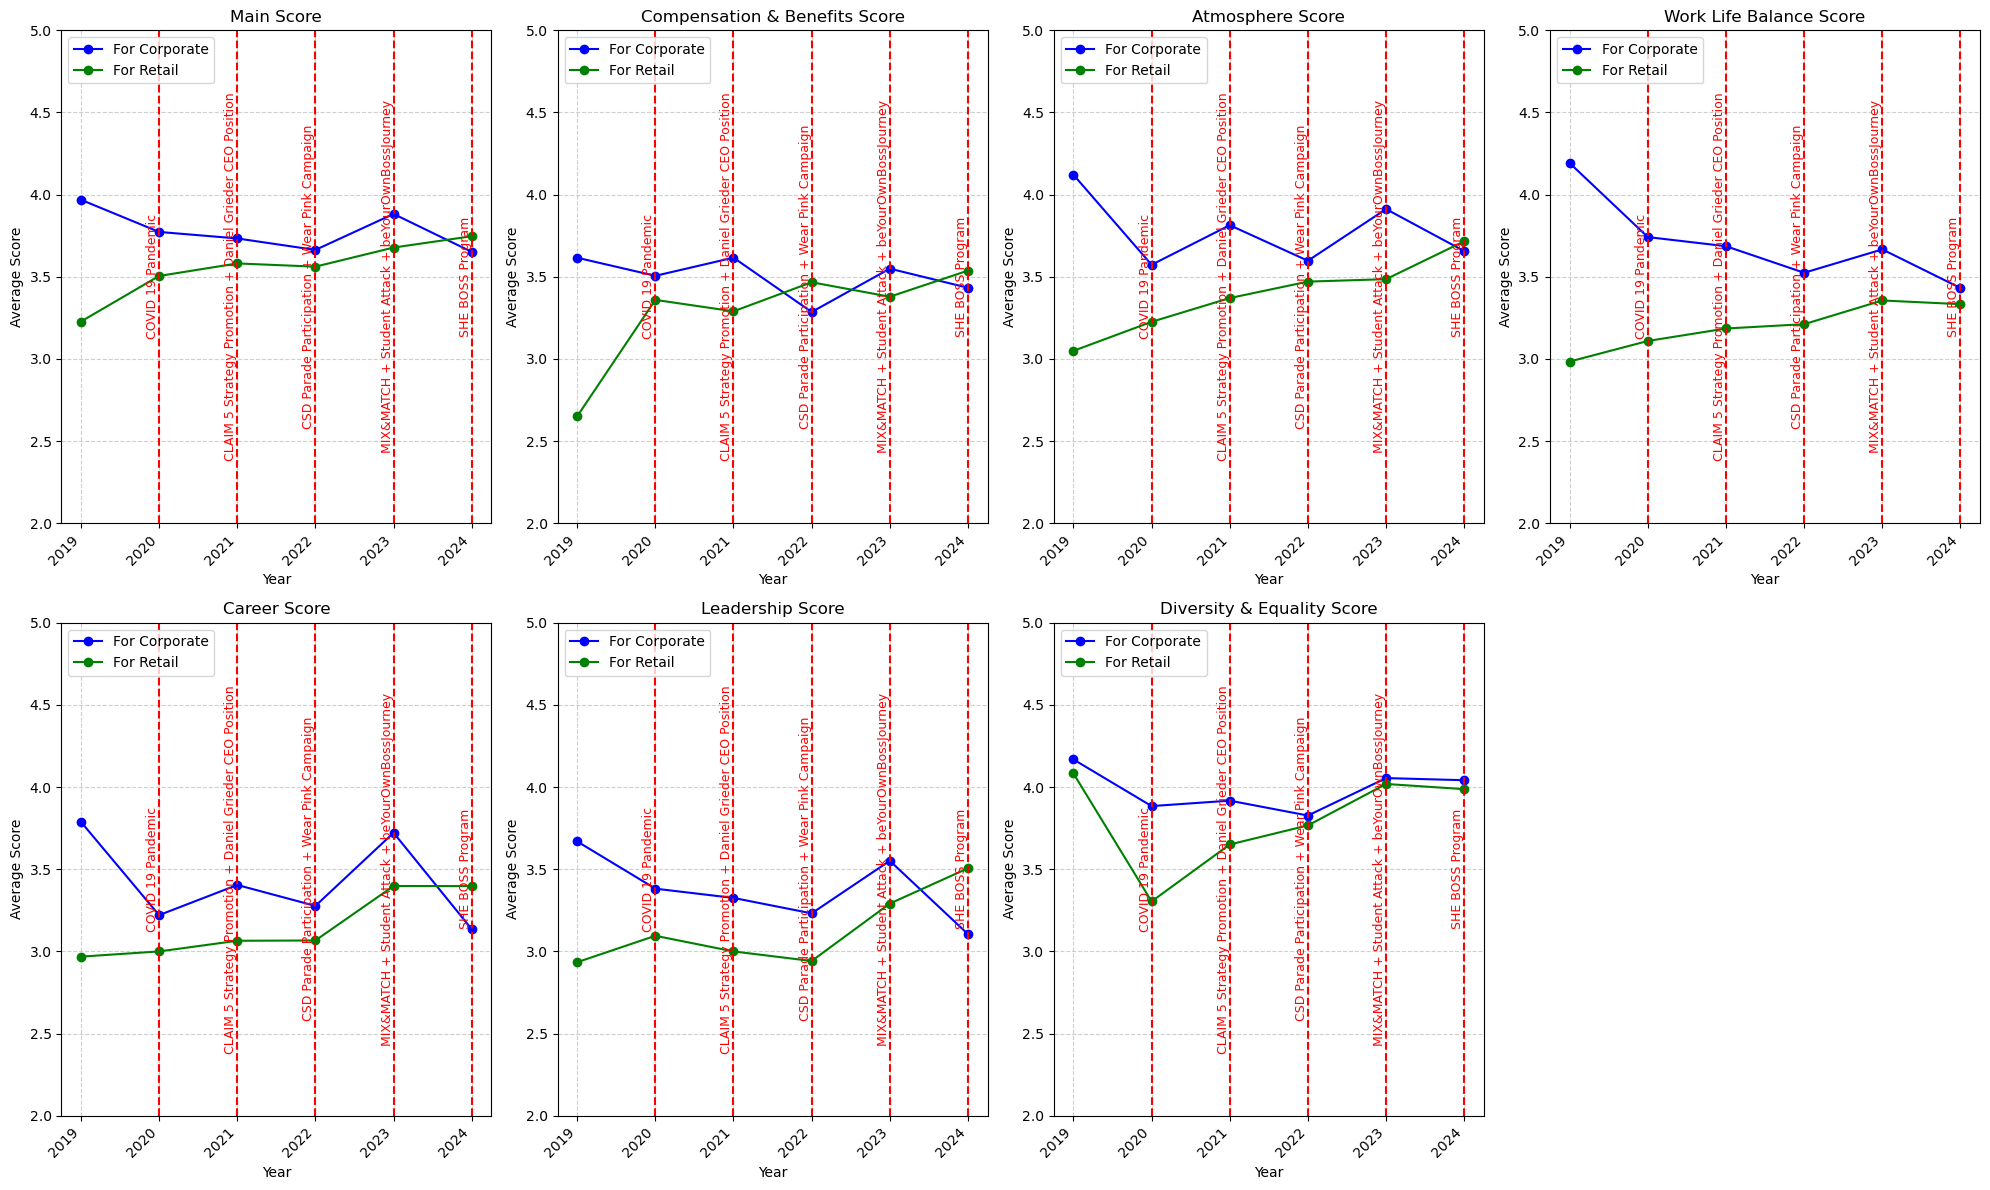

In [26]:
# We will only see Reatil VS Corporate as it makes more sense
n_cols = 4
n_rows = (len(score_columns) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows), constrained_layout=True)
score_columns = [
'Main Score', 'Compensation & Benefits Score', 'Atmosphere Score', 'Work Life Balance Score', 'Career Score', 'Leadership Score', 'Diversity & Equality Score'
]
axes = axes.flatten()

data_2 = combined_data_2[combined_data_2['business_function_department'] == 'Retail']
data_1 = combined_data_2[combined_data_2['business_function_department'] == 'Corporate']
data_2_label = 'For Retail'
data_1_label = 'For Corporate'
for ax, column in zip(axes, score_columns):
    create_year_subplot(ax, 'year', f'{column}', column, data_1, data_2, data_1_label, data_2_label, score_columns)
    add_campaign_lines_with_combined_labels(ax, campaigns_halfs)

for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])



plt.tight_layout()
plt.show()

In [27]:
# Lets See which Time series show significant change over the years department-wise

Anova_test_years(combined_data_2[combined_data_2['business_function_department'] == 'Retail'], 'Retail')
Anova_test_years(combined_data_2[combined_data_2['business_function_department'] == 'Corporate'], 'Corporate')

Germans_percantage = round(len(combined_data_2[combined_data_2['country'] == 'Germany']) / len(combined_data_2), 2)
print('percentage of retail:', round(len(combined_data_2[combined_data_2['business_function_department'] == 'Retail'])/len(combined_data_2),2))
print('percentage of corporate:', round(len(combined_data_2[combined_data_2['business_function_department'] == 'Corporate'])/len(combined_data_2),2))


For Retail :
No significant difference in Main Score across years (p-value: 0.101)
significant difference in Compensation & Benefits Score across years (p-value: 0.001)
No significant difference in Atmosphere Score across years (p-value: 0.091)
No significant difference in Work Life Balance Score across years (p-value: 0.560)
No significant difference in Career Score across years (p-value: 0.129)
No significant difference in Leadership Score across years (p-value: 0.083)
No significant difference in Diversity & Equality Score across years (p-value: 0.080)
For Corporate :
No significant difference in Main Score across years (p-value: 0.234)
No significant difference in Compensation & Benefits Score across years (p-value: 0.355)
significant difference in Atmosphere Score across years (p-value: 0.023)
significant difference in Work Life Balance Score across years (p-value: 0.000)
significant difference in Career Score across years (p-value: 0.001)
No significant difference in Leadership S

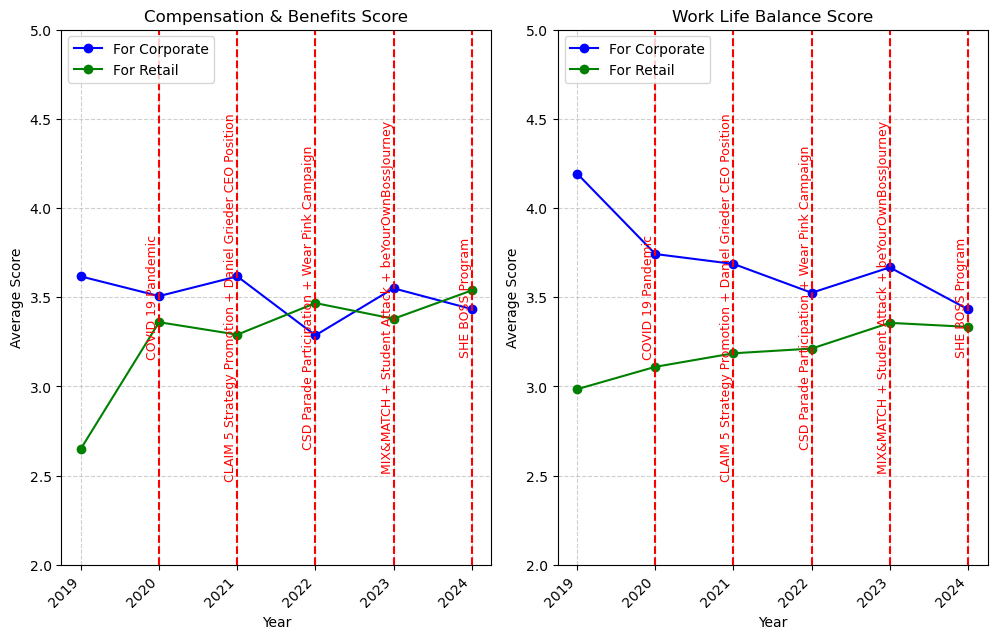

In [28]:
n_cols = 4
n_rows = (len(score_columns) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows), constrained_layout=True)
score_columns = [
'Compensation & Benefits Score', 'Work Life Balance Score',
]

axes = axes.flatten()

data_2 = combined_data_2[combined_data_2['business_function_department'] == 'Retail']
data_1 = combined_data_2[combined_data_2['business_function_department'] == 'Corporate']
data_2_label = 'For Retail'
data_1_label = 'For Corporate'
for ax, column in zip(axes, score_columns):
    create_year_subplot(ax, 'year', f'{column}', column, data_1, data_2, data_1_label, data_2_label, score_columns)
    add_campaign_lines_with_combined_labels(ax, campaigns_halfs)

for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

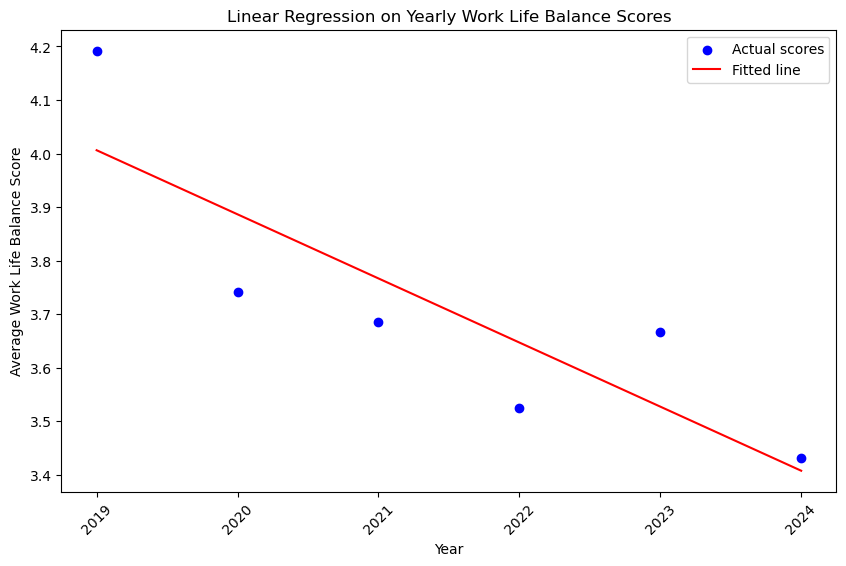

R-squared: 0.72


In [29]:
# Fitting a Linear Regression

data = combined_data_2[combined_data_2['business_function_department'] == 'Corporate']
data['cleaned_date'] = pd.to_datetime(data['cleaned_date'], errors='coerce')

data = data.set_index('cleaned_date')

grouped = data.groupby(pd.Grouper(freq='Y'))
yearly_averages = grouped['Work Life Balance Score'].mean().reset_index()

years = yearly_averages['cleaned_date'].dt.year.to_numpy()
average_scores = yearly_averages['Work Life Balance Score'].to_numpy()

start_date = years.min()
time_in_years = (years - start_date)

X = np.array(time_in_years).reshape(-1, 1) 
y = average_scores

# Fit the linear regression model
model = LinearRegression().fit(X, y)
predictions = model.predict(X)
r_squared = model.score(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(years, y, color='blue', label='Actual scores')
plt.plot(years, predictions, color='red', label='Fitted line')
plt.title('Linear Regression on Yearly Work Life Balance Scores')
plt.xlabel('Year')
plt.ylabel('Average Work Life Balance Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

print(f'R-squared: {r_squared:.2f}')


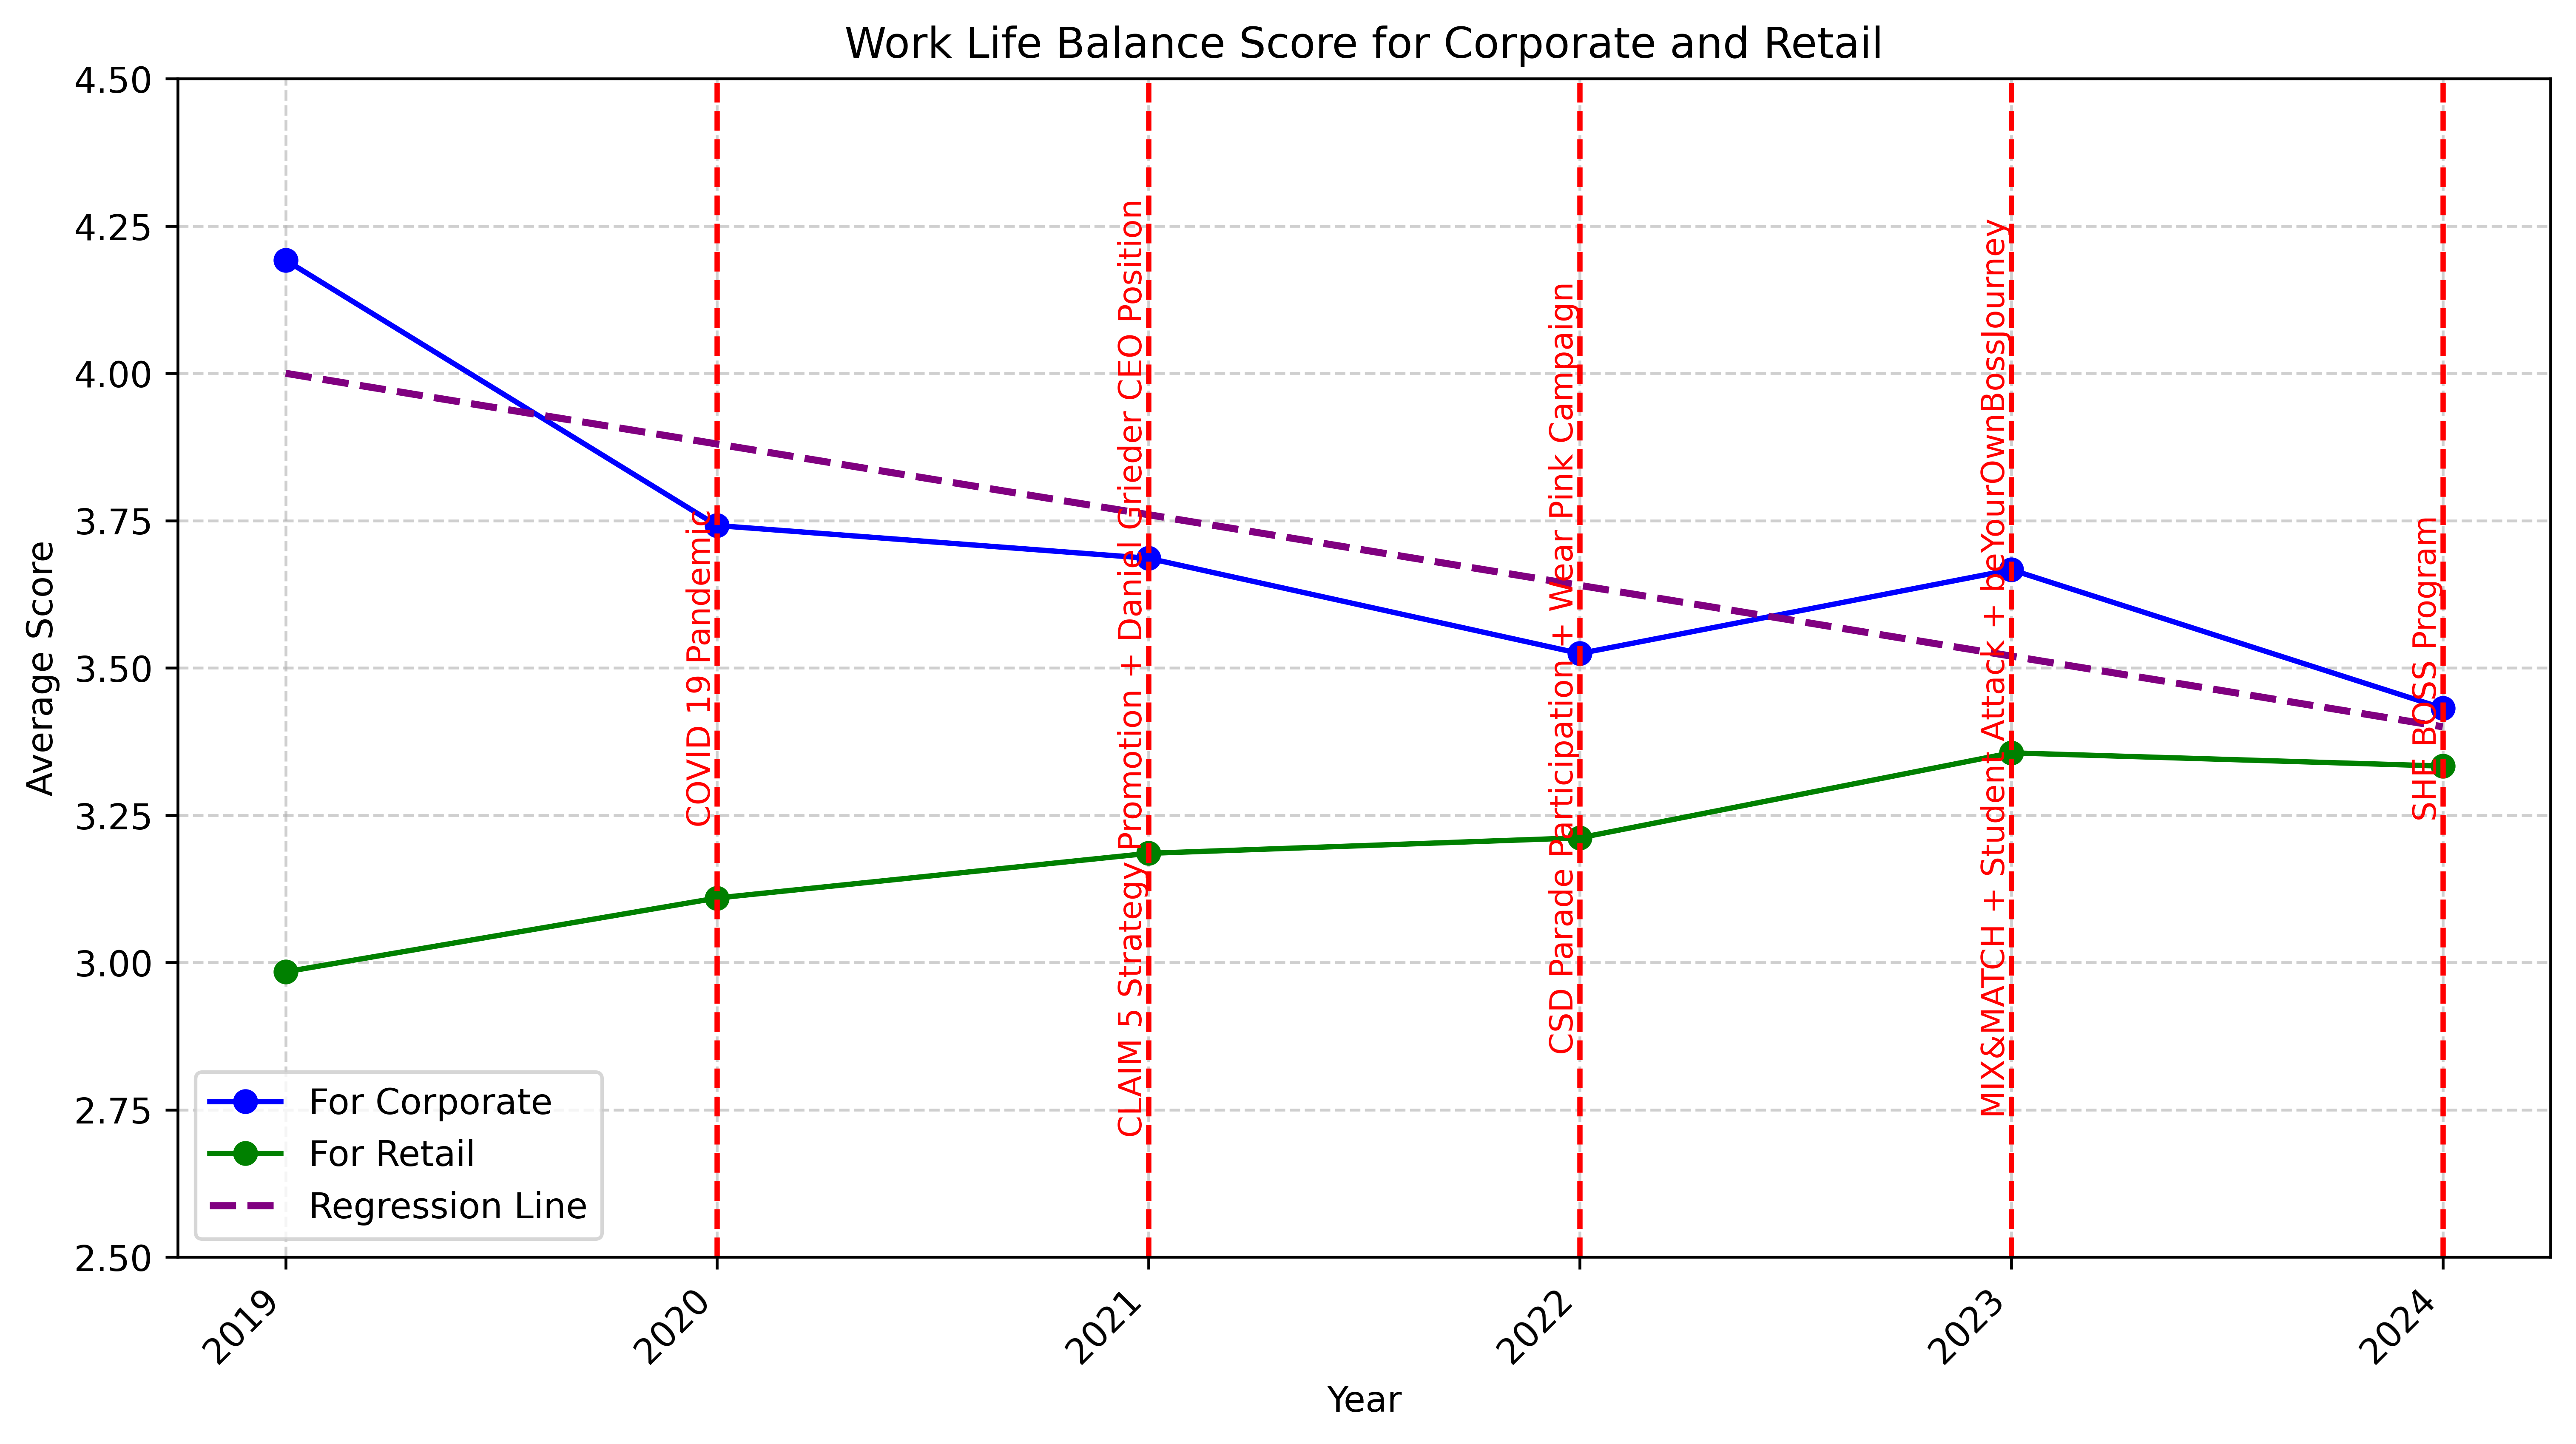

In [30]:
# Retail and Corporate work life balance Score

# p-value Corporate : 0.000 , p-value Retail : 0.56
data_2 = combined_data_2[combined_data_2['business_function_department'] == 'Retail']
data_1 = combined_data_2[combined_data_2['business_function_department'] == 'Corporate']
data_2_label = 'For Retail'
data_1_label = 'For Corporate'

# the start and end coordinates for the regression line
start_year = 2019
start_score = 4.0
end_year = 2024
end_score = 3.4

create_single_plot_with_regression('year', 'Work Life Balance Score for Corporate and Retail', 'Work Life Balance Score', data_1, data_2, data_1_label, data_2_label, campaigns_halfs,2.5,4.5,start_year, start_score, end_year, end_score)


**Work Life Balance Score:**
- We dont have significancy for retail in this, therefore we cant say the upward trend is acceptable.
- But for the Corporate sector the results are significant, and it shows that for corporate sector in hugo boss work life balance is getting worse year by year.

**Compensation and benefits score:**
- We dont have significancy for corporate in this score.
- But for Retail sector which is significant, we can see that workers are getting happier year by year with their benefirts and compensation.





### Stratify based on position

In [31]:
combined_data_2['cleaned_position'].value_counts(dropna=False)

employee    1081
manager      393
other        267
Junior       180
Name: cleaned_position, dtype: int64

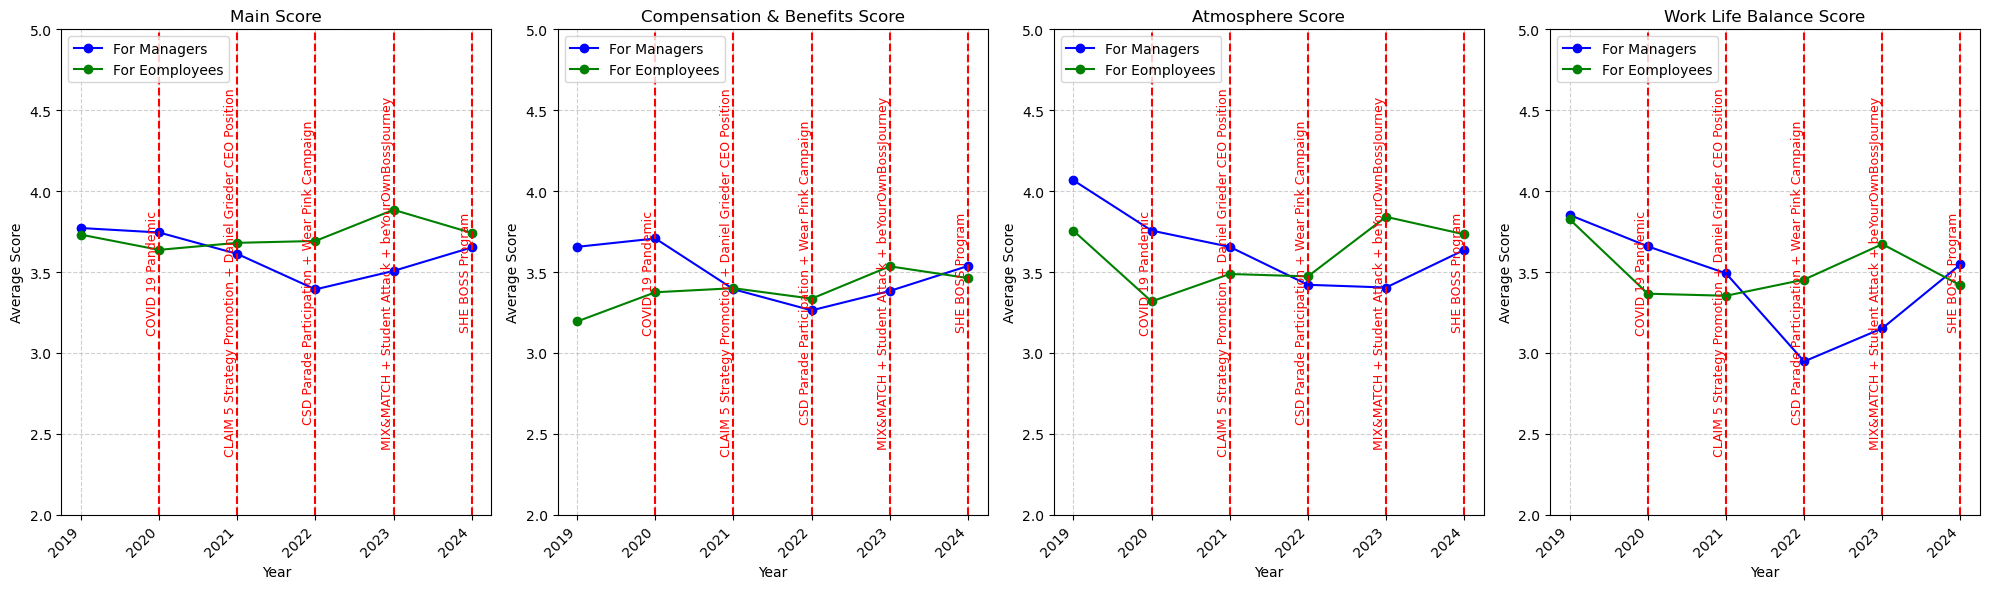

In [32]:
# We will only see Employee VS Managers as it makes more sensen_cols = 4
n_rows = (len(score_columns) + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows), constrained_layout=True)
score_columns = [
'Main Score', 'Compensation & Benefits Score', 'Atmosphere Score', 'Work Life Balance Score', 'Career Score', 'Leadership Score', 'Diversity & Equality Score'
]

axes = axes.flatten()

data_2 = combined_data_2[combined_data_2['cleaned_position'] == 'employee']
data_1 = combined_data_2[combined_data_2['cleaned_position'] == 'manager']
data_2_label = 'For Eomployees'
data_1_label = 'For Managers'
for ax, column in zip(axes, score_columns):
    create_year_subplot(ax, 'year', f'{column}', column, data_1, data_2, data_1_label, data_2_label, score_columns)
    add_campaign_lines_with_combined_labels(ax, campaigns_halfs)

for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [33]:
# Lets See which Time series show significant change over the years seniority-wise

Anova_test_years(combined_data_2[combined_data_2['cleaned_position'] == 'employee'], 'Employees')
Anova_test_years(combined_data_2[combined_data_2['cleaned_position'] == 'manager'], 'Managers')

print('percentage of employees:', round(len(combined_data_2[combined_data_2['cleaned_position'] == 'employee'])/len(combined_data_2),2))
print('percentage of managers:', round(len(combined_data_2[combined_data_2['cleaned_position'] == 'manager'])/len(combined_data_2),2))


For Employees :
No significant difference in Main Score across years (p-value: 0.402)
No significant difference in Compensation & Benefits Score across years (p-value: 0.244)
significant difference in Atmosphere Score across years (p-value: 0.010)
significant difference in Work Life Balance Score across years (p-value: 0.009)
significant difference in Career Score across years (p-value: 0.002)
significant difference in Leadership Score across years (p-value: 0.016)
significant difference in Diversity & Equality Score across years (p-value: 0.001)
For Managers :
No significant difference in Main Score across years (p-value: 0.536)
No significant difference in Compensation & Benefits Score across years (p-value: 0.364)
No significant difference in Atmosphere Score across years (p-value: 0.109)
significant difference in Work Life Balance Score across years (p-value: 0.006)
significant difference in Career Score across years (p-value: 0.027)
No significant difference in Leadership Score ac

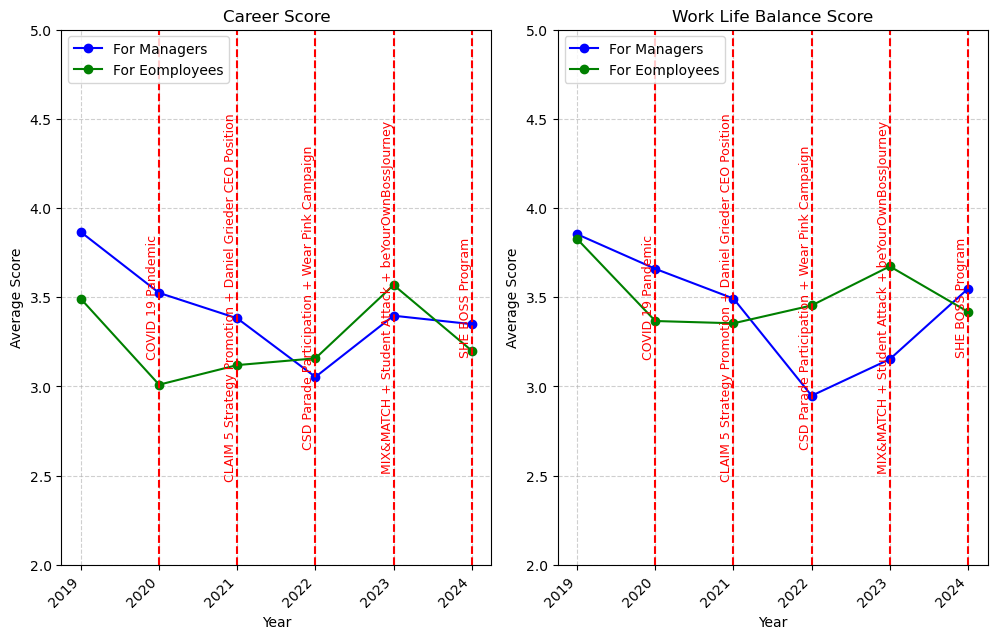

In [34]:

n_cols = 4
n_rows = (len(score_columns) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows), constrained_layout=True)
score_columns = [
'Career Score', 'Work Life Balance Score'
]

axes = axes.flatten()

data_2 = combined_data_2[combined_data_2['cleaned_position'] == 'employee']
data_1 = combined_data_2[combined_data_2['cleaned_position'] == 'manager']
data_2_label = 'For Eomployees'
data_1_label = 'For Managers'
for ax, column in zip(axes, score_columns):
    create_year_subplot(ax, 'year', f'{column}', column, data_1, data_2, data_1_label, data_2_label, score_columns)
    add_campaign_lines_with_combined_labels(ax, campaigns_halfs)

for i in range(len(score_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### End of Notebook